In [1]:
import numpy as np
import scipy.io as si
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy
from netCDF4 import Dataset
import pickle
import datetime
from scipy.optimize import fmin
from scipy.signal import savgol_filter
# functions I've written
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 36
ref_lon = 64.2

# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 40
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 4000  # 3900

In [2]:
# --- LOAD in initial processing results
# these include, raw profiles, velocity profiles, displacement profiles, background density profiles...
pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg041_2018_initial_processing.pkl', 'rb')
IP = pickle.load(pkl_file)
pkl_file.close()
ref_lon = IP['ref_lon']
ref_lat = IP['ref_lat']
grid = IP['depth']
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
profile_tags = IP['raw_profile_tags']
sa = IP['sa']
ct = IP['ct']
gamma = IP['gamma']
lon = IP['lon']
lat = IP['lat']
prof_time = IP['profile_time']
bckgrds = IP['background_indices']
bckgrds_key = IP['background key']
bd1 = IP['bd1']
bd2 = IP['bd2']
bd3 = IP['bd3']
dac_u = IP['dac_u']
dac_v = IP['dac_v']

N2 = IP['N2_by_season_quad']
sa_avg = IP['bckgrd_sa']
ct_avg = IP['bckgrd_ct']
theta_avg = IP['bckgrd_theta']
gamma_avg = IP['bckgrd_gamma']
mw_time = IP['mw_time']
mw_lon = IP['mw_lon']
mw_lat = IP['mw_lat']
mw_ct = IP['mw_ct']
mw_sa = IP['mw_sa']
mw_gamma = IP['mw_gamma']
mw_eta_1 = IP['eta_1']
mw_eta_2 = IP['eta_2']
mw_eta_3 = IP['eta_3']
eta_ind_1 = IP['eta_per_1']
eta_ind_3 = IP['eta_per_3']

mw_time_good = IP['mw_time_good']
gamma_good = IP['mw_gamma_good']
mw_eta_1_good = IP['eta_1_good']
mw_eta_2_good = IP['eta_2_good']
mw_eta_3_good = IP['eta_3_good']
mw_v_good = IP['dg_v_good']
mw_v_e_good = IP['dg_v_e_good']
mw_v_n_good = IP['dg_v_n_good']
mw_prof_good = IP['mw_prof_good']
PE_per_prof = IP['PE_per_prof']

t_s = datetime.date.fromordinal(np.int(np.nanmin(prof_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(prof_time)))

(248,)

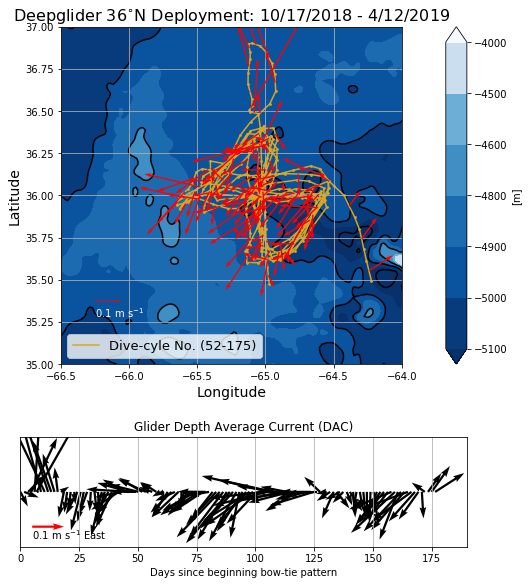

In [70]:
# PLAN VIEW PLOt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

bath = '/Users/jake/Desktop/bats/bats_bathymetry/etopo180_3e57_6032_17e3.nc'
bath_fid = Dataset(bath, 'r')
bath_lon = bath_fid.variables['longitude'][:]
bath_lat = bath_fid.variables['latitude'][:]
bath_z = bath_fid.variables['altitude'][:]
levels = [-5100, -5000, -4900, -4800, -4600, -4500, -4000]

matplotlib.rcParams['figure.figsize'] = (8, 8)
fig0 = plt.figure(figsize=(8, 10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3.5, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
cmap = plt.cm.get_cmap("Blues_r")
bc = ax0.contourf(bath_lon, bath_lat, bath_z, levels, cmap='Blues_r', extend='both', zorder=0)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
bcl = ax0.contour(bath_lon, bath_lat, bath_z, [-5400, -5200, -5000, -4800], colors='k', zorder=1)
ax0.clabel(bcl, inline_spacing=-3, fmt='%1.0f', colors='k')

ax0.scatter(mw_lon, mw_lat, s=3, color='#DAA520')
ax0.plot(mw_lon, mw_lat, color='#DAA520',
        label='Dive-cyle No. (' + str(int(profile_tags[0])) + '-' + str(int(profile_tags[-2])) + ')', zorder=1)

tdu = np.nan * np.ones(124)
tdv = np.nan * np.ones(124)
tlon = np.nan * np.ones(124)
tlat = np.nan * np.ones(124)
tt = np.nan * np.ones(124)
count = 0
for i in range(0, 248, 2):
    tdu[count] = dac_u[i]
    tdv[count] = dac_v[i]
    tlon[count] = np.nanmean(mw_lon[i:i+2])
    tlat[count] = np.nanmean(mw_lat[i:i+2])
    tt[count] = np.nanmean(prof_time[i:i+2])
    count = count + 1

ax0.quiver(tlon, tlat, tdu, tdv, color='r', scale=1.3, width=0.004, zorder=2)
ax0.quiver(-66.25, 35.375, 0.1, 0, color='r', scale=1.3, width=0.0025, zorder=2)
ax0.text(-66.25, 35.275, r'0.1 m s$^{-1}$', color='w' )

# ax0.plot([-70, -69], [30.3, 30.3], color='w', zorder=2)
# ax0.text(-69.7, 30.2, '96 km', color='w', fontsize=14, fontweight='bold')

w = 1 / np.cos(np.deg2rad(ref_lat))
ax0.axis([-66.5, -64, 35, 37])
ax0.set_aspect(w)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig0.colorbar(bc, cax=cax, label='[m]')
ax0.set_xlabel('Longitude', fontsize=14)
ax0.set_ylabel('Latitude', fontsize=14)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=13)
ax0.set_title(r'Deepglider 36$^{\circ}$N Deployment: ' + np.str(t_s.month) + '/' + np.str(t_s.day) + '/' + np.str(
    t_s.year) + ' - ' + np.str(t_e.month) + '/' + np.str(t_e.day) + '/' + np.str(t_e.year), fontsize=16)
# plt.tight_layout()
ax0.grid()

ax1.quiver(tt - np.nanmin(tt), np.zeros(len(tdu)), tdu, tdv, scale=1.4, width=0.005) 
ax1.set_xlim([0, 190])
ax1.set_xlabel('Days since beginning bow-tie pattern')
ax1.set_title('Glider Depth Average Current (DAC)')
ax1.quiver(5, -.19, 0.1, 0, color='r', scale=1.4, width=0.005, zorder=2)
ax1.text(5, -.26, r'0.1 m s$^{-1}$ East', color='k' )
ax1.set_ylim([-.3, .3])
ax1.axes.get_yaxis().set_ticks([])
plot_pro(ax1)
fig0.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/n36_2018_plan.jpg", dpi=300)

In [65]:
# T/S variability (and correlations) on isopycnals 
rho_1 = 27.5, 27.8, 27.98, 28.05, 28.1, 28.11, 28.1275  # , 28.13, 28.133
spice = np.nan * np.ones((lon.shape[1], len(rho_1)))
ct_r = np.nan * np.ones((lon.shape[1], len(rho_1)))
dep_rec = np.nan * np.ones((lon.shape[1], len(rho_1)))
lon_in = np.nan * np.ones((lon.shape[1], len(rho_1)))
lat_in = np.nan * np.ones((lon.shape[1], len(rho_1)))
for m in range(len(rho_1)):
    for i in range(lon.shape[1]):
        z_on = np.interp(rho_1[m], gamma[:, i], grid)
        dep_rec[i, m] = z_on
        sa_in = np.interp(z_on, grid, sa[:, i])
        ct_in = np.interp(z_on, grid, ct[:, i])
        lon_in[i, m] = np.interp(z_on, grid, lon[:, i])
        lat_in[i, m] = np.interp(z_on, grid, lat[:, i])
        spice[i, m] = gsw.spiciness1(sa_in, ct_in)  # number of observations at each isopycnal m 
        ct_r[i, m] = ct_in  # number of observations at each isopycnal m 

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in less
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:71: RuntimeWarning: Mean of empty slice


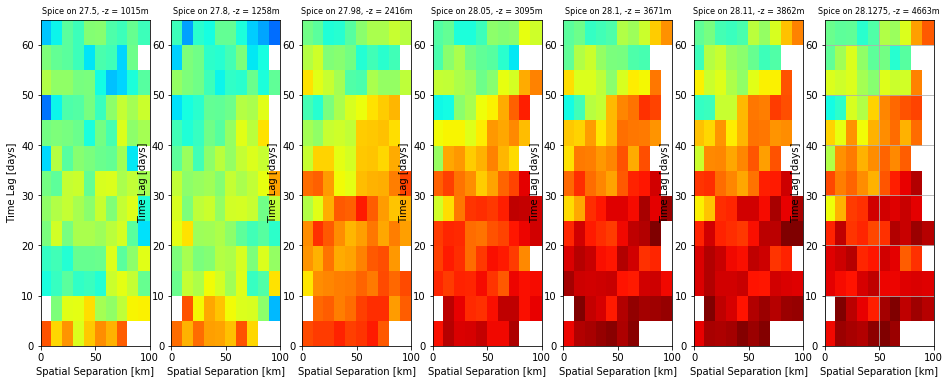

()

In [12]:
# ---------------------------
# Mode Amplitude Correlations 
matplotlib.rcParams['figure.figsize'] = (16,6)    
dist_win = np.arange(-100, 105, 2)
t_win = np.arange(0, 80, 2)
dist_t_win = np.arange(0, 105, 10)
t_t_win = np.arange(0, 70, 5)
avg_cor = np.nan * np.ones((len(t_t_win), len(rho_1)))
f, ax = plt.subplots(1, len(rho_1))
cmap = plt.cm.jet
for l in range(len(rho_1)):
    x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (lon_in[:, l] - ref_lon) / 1000
    y = 1852 * 60 * (lat_in[:, l] - ref_lat) / 1000
    t = prof_time.copy()  # time_rec_bin.copy()
    vari = ct_r
    
    # distances/times apart
    for i in range(len(x) - 1):  # loop through each observation 
        if i < 1:
            dist_x = x[i+1:] - x[i] 
            dist_y = y[i+1:] - y[i]
            # distance between this obs x[i], y[i] and all observations further down the list 
            dist_t = np.sqrt(dist_x**2 + dist_y**2) 
            # temporal separation between this obs at t[i] and all obs at t[i+1] to end of list 
            time_l = np.abs(t[i] - t[i+1:])
            # two rows, repeated spice of this obs (row 1) and spice of all obs further down the list 
            spice_count = np.array((vari[i, l] * np.ones(len(x[i+1:])), vari[i+1:, l]))
        else:
            # append each subsequent obs i to these variables 
            dist_x = np.concatenate((dist_x, x[i+1:] - x[i]))
            dist_y = np.concatenate((dist_y, y[i + 1:] - y[i]))
            dist_t = np.concatenate((dist_t, np.sqrt((x[i+1:] - x[i])**2 + (y[i+1:] - y[i])**2)))
            time_l = np.concatenate((time_l, np.abs(t[i] - t[i+1:])))
            spice_count = np.concatenate((spice_count, 
                                          np.array((vari[i, l] * np.ones(len(x[i + 1:])), vari[i + 1:, l]))), axis=1)
        # note each loop, the list x[i+1:] shortens 
        # the goal is a list of pairs coupled with lists of time/space separations 
        
    # define each box as all points that fall within a time and space lag
    corr_i_z = np.nan * np.zeros((len(t_win), len(dist_win)))
    corr_i_z2 = np.nan * np.zeros((len(t_win), len(dist_win)))
    corr_i_all = np.nan * np.zeros((len(t_t_win), len(dist_t_win)))

    # spatial separation             
    for dd in range(len(dist_t_win) - 1):
        for tt in range(len(t_t_win) - 1):
            # for each box, find time/space lags that fit in box 
            in_box = np.where((dist_t > dist_t_win[dd]) & (dist_t < dist_t_win[dd + 1]) &
                                (time_l > t_t_win[tt]) & (time_l < t_t_win[tt + 1]))[0]
            # only compute statistics if number is greater than ___ 
            if len(in_box) > 25:
#                 inski_with = spice_count[:, in_box]
#                 inski = np.unique(spice_count[:, in_box])
#                 i_mean = np.nanmean(inski) # mean of all samples in box 
#                 n = len(inski)
#                 sstd = np.nanstd(inski)
#                 covi = (inski) * (inski)
#                 corr_i_all[tt, dd] = (1 / (n - 0)) * (np.nansum(covi))   
                
                # pairs that fall in each box 
                inski_with = spice_count[:, in_box]                   
                inski, inski_i = np.unique(spice_count[:, in_box], return_index=True)
                i_mean = np.nanmean(inski)
                n = len(inski_with[0, :]) # number of pairs
                variance = np.nanvar(inski)
                covi = (inski_with[0, :] - i_mean) * (inski_with[1, :] - i_mean)
                corr_i_all[tt, dd] = (1 / ((n) * variance)) * np.nansum(covi) 

                
    avg_cor[:, l] = np.nanmean(corr_i_all[:, 2:15], axis=1)
    corr_i_all[np.isnan(corr_i_all)] = -999
    pa = ax[l].pcolor(dist_t_win, t_t_win, corr_i_all, vmin=-1, vmax=1, cmap=cmap)
    cmap.set_under('w')
    ax[l].set_xlabel('Spatial Separation [km]')
    ax[l].set_ylabel('Time Lag [days]')
    ax[l].set_title('Spice on ' + str(rho_1[l]) + ', -z = ' + str(np.int(np.nanmean(dep_rec[:, l]))) + 'm', fontsize=8)
# plt.colorbar(pa, label='Correlation')
plot_pro(ax[l])                  

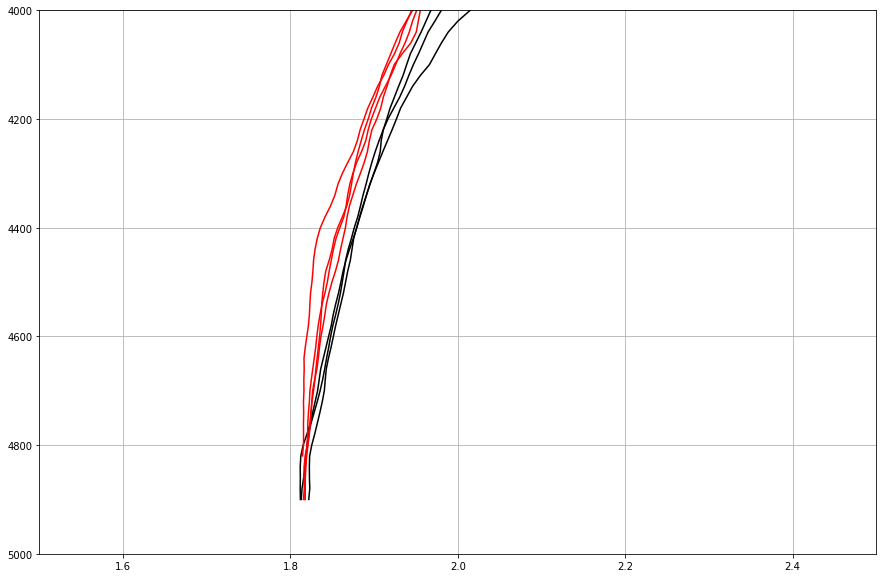

()

In [100]:
# test to see deep influence on T/S of rings 
f, ax = plt.subplots()
ax.plot(ct[:, profile_tags == 166], grid, color='k')
ax.plot(ct[:, profile_tags == 167], grid, color='k')
ax.plot(ct[:, profile_tags == 168], grid, color='k')
ax.plot(ct[:, profile_tags == 169], grid, color='r')
ax.plot(ct[:, profile_tags == 170], grid, color='r')
ax.plot(ct[:, profile_tags == 171], grid, color='r')
ax.plot(ct[:, profile_tags == 172], grid, color='r')
ax.set_ylim([4000, 5000])
ax.set_xlim([1.5, 2.5])
ax.invert_yaxis()
plot_pro(ax)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


[array([  55.5,   56. ,   56.5,   58. ,   58.5,   59. ,   59.5,   60. ,
         87.5,   88. ,   88.5,   89. ,  170.5,  171. ,  171.5,  172. ,
        172.5,  173. ])]
[array([ 171.5])]
500


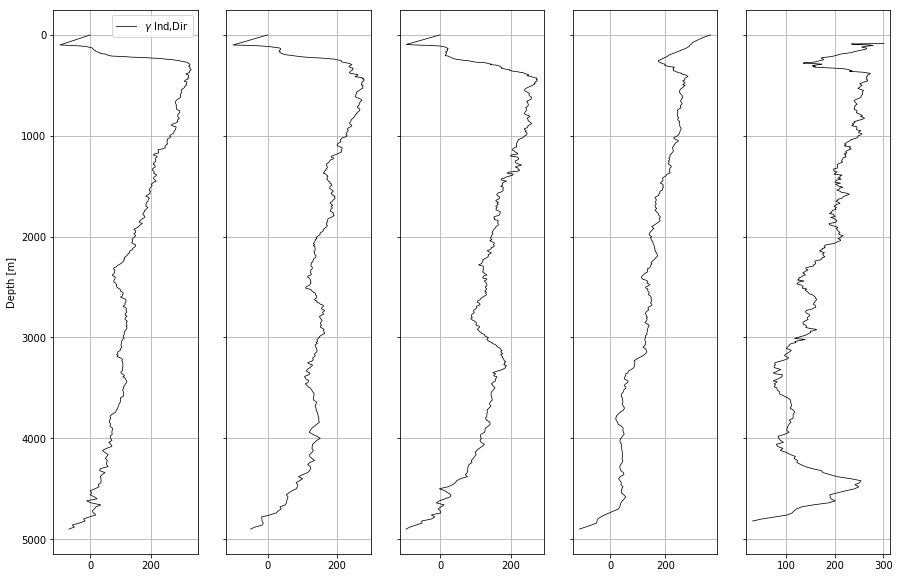

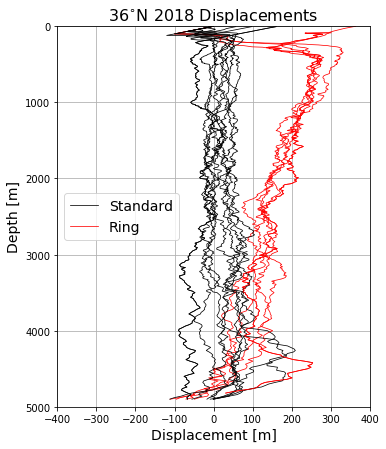

In [38]:
# find displacement profiles of rings 
ringo_ind = np.where(np.abs(eta_ind_3[100, :]) > 125)[0]
ringo = np.where(np.abs(mw_eta_3_good[100, :]) > 150)[0]
print([profile_tags[ringo_ind]])
print([mw_prof_good[ringo]])
print(grid[100])
these_profiles = np.array([55.5, 56.5, 58.5, 171.5, 172])
plt.rcParams['figure.figsize'] = 15, 10
f, ax = plt.subplots(1, 5, sharey=True)
for i in range(5):
    ind_rel = profile_tags == these_profiles[i]
    ax[i].plot(eta_ind_3[:, ind_rel], grid, color='k', linewidth=0.75, label=r'$\gamma$ Ind,Dir')  # individual profiles direct search, gamma
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, fontsize=10)
ax[0].set_ylabel('Depth [m]')
ax[4].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
plot_pro(ax[4])


matplotlib.rcParams['figure.figsize'] = (5.6, 7)
f, ax = plt.subplots()
for i in range(5):
    ind_rel = profile_tags == these_profiles[i]
    ax.plot(eta_ind_3[:, ind_rel], grid, color='r', linewidth=0.75)  # individual profiles direct search, gamma

b_p_l = [0, 11, 22, 33, 44, 66, 77, 88, 99, 120]
for i in b_p_l:
    ax.plot(eta_ind_3[:, i], grid, color='k', linewidth=0.75)

ax.plot(eta_ind_3[:, i], grid, color='k', linewidth=0.75, label='Standard')
ax.plot(eta_ind_3[:, ind_rel], grid, color='r', linewidth=0.75, label='Ring')    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
ax.set_ylabel('Depth [m]', fontsize=14)
ax.set_xlabel('Displacement [m]', fontsize=14)
ax.set_title('36$^{\circ}$N 2018 Displacements', fontsize=16)
ax.set_xlim([-400, 400])
ax.set_ylim([0, 5000])
ax.invert_yaxis()
plot_pro(ax)
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_05_17/36n_disps_ring.jpg", dpi=300)

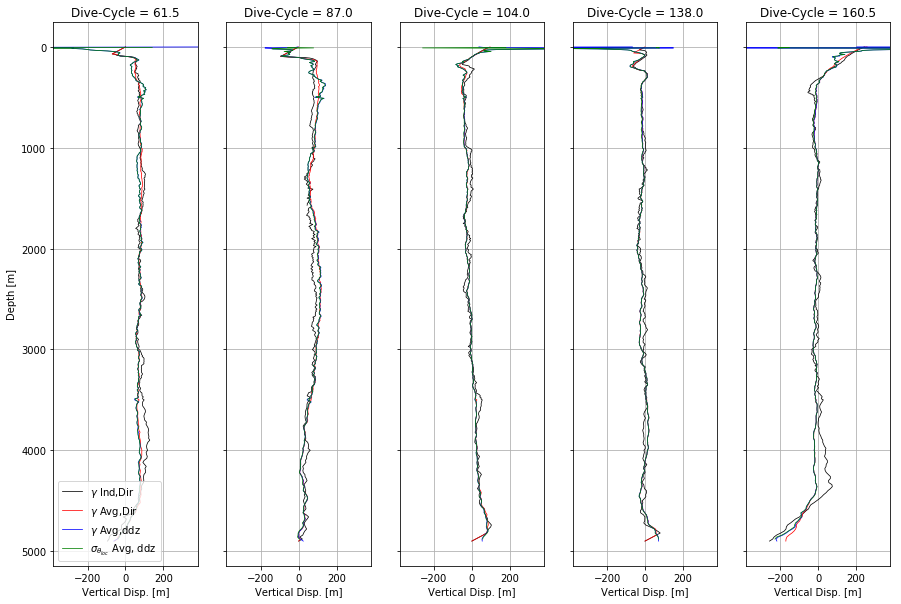

()

In [3]:
# these_profiles = np.array([59, 62.5, 63.5, 69, 77])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([113, 113.5, 114, 114.5, 115])  # dive numbers of profiles to compare (individual dives)
these_profiles = np.array([61.5, 87, 104, 138, 160.5])
# these_profiles = np.array([67, 68, 69, 70, 71])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([72, 72.5, 73, 73.5, 74])  # dive numbers of profiles to compare (individual dives)

plt.rcParams['figure.figsize'] = 15, 10
f, ax = plt.subplots(1, 5, sharey=True)
for i in range(5):
    ind_rel = profile_tags == these_profiles[i]
    avg_rel = mw_prof_good == these_profiles[i]
    ax[i].plot(eta_ind_3[:, ind_rel], grid, color='k', linewidth=0.75, label=r'$\gamma$ Ind,Dir')  # individual profiles direct search, gamma
    ax[i].plot(mw_eta_3_good[:, avg_rel], grid, color='r', linewidth=0.75, label=r'$\gamma$ Avg,Dir')  # avg direct search, gamma
    ax[i].plot(-1 * mw_eta_1_good[:, avg_rel], grid, color='b', linewidth=0.75, label=r'$\gamma$ Avg,ddz')  # avg divide by ddz, gamma
    ax[i].plot(-1 * mw_eta_2_good[:, avg_rel], grid, color='g', linewidth=0.75, label=r'$\sigma_{\theta_{loc}}$ Avg, ddz')  # avg divide by ddz, pot den, local pref
    ax[i].set_xlim([-380, 380])
    ax[i].set_title('Dive-Cycle = ' + str(these_profiles[i]))
    ax[i].set_xlabel('Vertical Disp. [m]', fontsize=10)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, fontsize=10)
ax[0].set_ylabel('Depth [m]')
ax[4].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
plot_pro(ax[4])

In [4]:
# --- VERTICAL MODES ---
# --- compute vertical mode shapes
# by season
G_0, Gz_0, c_0, epsilon_0 = vertical_modes(N2[:, 0], grid, omega, mmax)  # fall
G_1, Gz_1, c_1, epsilon_1 = vertical_modes(N2[:, 1], grid, omega, mmax)  # winter1
G_2, Gz_2, c_2, epsilon_2 = vertical_modes(N2[:, 2], grid, omega, mmax)  # winter2
Gs = [G_0, G_1, G_2]
Gzs = [Gz_0, Gz_1, Gz_2]
cs = [c_0, c_1, c_2]
epsilons = [epsilon_0, epsilon_1, epsilon_2]
# test using average over entire year
G_tot, Gz_tot, c_tot, epsilon_tot = vertical_modes(np.nanmean(N2, axis=1), grid, omega, mmax)  # N2

# --- compute alternate vertical modes
bc_bot = 1  # 1 = flat, 2 = rough
slope = 1.0*10**(-3)
grid2 = np.concatenate([np.arange(0, 150, 10), np.arange(150, 300, 10), np.arange(300, 4500, 10)])
n2_interp = np.interp(grid2, grid, np.nanmean(N2, axis=1))
n2_interp[0] = n2_interp[1] - 0.000001
F_int_g2, F_g2, c_ff, norm_constant, epsilon2 = vertical_modes_f(n2_interp, grid2, omega, mmax, bc_bot, ref_lat, slope)
F = np.nan * np.ones((np.size(grid), mmax + 1))
F_int = np.nan * np.ones((np.size(grid), mmax + 1))
for i in range(mmax + 1):
    F[:, i] = np.interp(grid, grid2, F_g2[:, i])
    F_int[:, i] = np.interp(grid, grid2, F_int_g2[:, i])

# --- test season differences in modes
cols = ['#DAA520', 'b', '#800080', '#2F4F4F'] # yellow, blue, ring_color, grey
season_labs = ['Fall', 'Winter', 'Ring']
# season order, fall, winter1, winter2 (use same colors as BATS: reorder to yellow, blue, grey (no summer/red))
# BATS order
# cols = ['#2F4F4F', '#FF4500', '#DAA520', '#800080']
# season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [5]:
# these are the indices that satisfy the different seasons
d2_fall = np.where(mw_time_good < bd1)[0]
d2_winter1 = np.where((mw_time_good > bd1) & (mw_time_good < bd2))[0]
d2_winter2 = np.where((mw_time_good > bd2) & (mw_time_good < bd3))[0]
bckgrds2 = [d2_fall, d2_winter1, d2_winter2]

np.shape(N2)

(471, 4)

In [35]:
print(epsilon_1[1, 1, 1])
print(epsilon_1[2, 2, 2])
print(epsilon_1[3, 3, 3])

1.53039724564
-0.322549013981
-0.198847744117


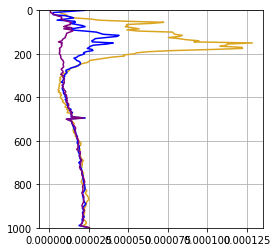

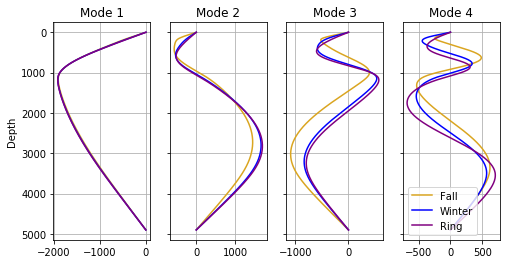

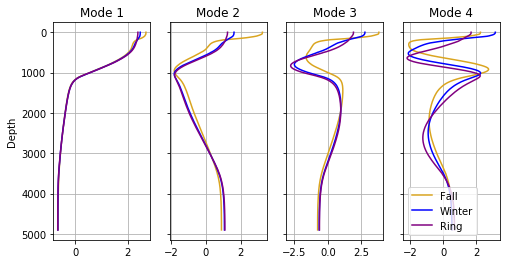

()

In [6]:
# PLOT --- test season differences in modes
plt.rcParams['figure.figsize'] = 4, 4
f, ax = plt.subplots()
ax.plot(N2[:, 0], grid, color=cols[0])
ax.plot(N2[:, 1], grid, color=cols[1])
ax.plot(N2[:, 2], grid, color=cols[2])
ax.set_ylim([0, 1000])
ax.invert_yaxis()
plot_pro(ax)

plt.rcParams['figure.figsize'] = 8, 4
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(len(Gs)):
    ax1.plot(Gs[i][:, 1], grid, color=cols[i])
    ax2.plot(Gs[i][:, 2], grid, color=cols[i])
    ax3.plot(Gs[i][:, 3], grid, color=cols[i])
    ax4.plot(Gs[i][:, 4], grid, color=cols[i], label=season_labs[i])
ax1.set_title('Mode 1')
ax1.set_ylabel('Depth')
ax1.grid()
ax2.set_title('Mode 2')
ax2.grid()
ax3.set_title('Mode 3')
ax3.grid()
ax4.set_title('Mode 4')
ax4.invert_yaxis()
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=10)
plot_pro(ax4)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(len(Gs)):
    ax1.plot(Gzs[i][:, 1], grid, color=cols[i])
    ax2.plot(Gzs[i][:, 2], grid, color=cols[i])
    ax3.plot(Gzs[i][:, 3], grid, color=cols[i])
    ax4.plot(Gzs[i][:, 4], grid, color=cols[i], label=season_labs[i])
ax1.set_title('Mode 1')
ax1.set_ylabel('Depth')
ax1.grid()
ax2.set_title('Mode 2')
ax2.grid()
ax3.set_title('Mode 3')
ax3.grid()
ax4.set_title('Mode 4')
ax4.invert_yaxis()
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, fontsize=10)
plot_pro(ax4)

In [7]:
# ---- PROJECT MODES ONTO EACH PROFILE -------
# ---- Velocity and Eta (ENERGY)
sz = np.shape(mw_eta_3_good)
num_profs = sz[1]
AG = np.zeros([nmodes, num_profs])
AGz = np.zeros([nmodes, num_profs])
Eta_m = np.nan * np.zeros([np.size(grid), num_profs])
V_m = np.nan * np.zeros([np.size(grid), num_profs])
Neta = np.nan * np.zeros([np.size(grid), num_profs])
NEta_m = np.nan * np.zeros([np.size(grid), num_profs])
PE_per_mass = np.nan * np.zeros([nmodes, num_profs])
HKE_per_mass = np.nan * np.zeros([nmodes, num_profs])
modest = np.arange(11, nmodes)
good_ke_prof = np.ones(num_profs)
good_pe_prof = np.ones(num_profs)
HKE_noise_threshold = 1 * 1e-5  # 1e-5
PE_noise_threshold = 1e5
for i in range(num_profs):
    if len(np.intersect1d(d2_fall, i)):
        G = G_0
        Gz = Gz_0
        c = c_0
        this_N2 = N2[:, 0]
    elif len(np.intersect1d(d2_winter1, i)):
        G = G_1
        Gz = Gz_1
        c = c_1
        this_N2 = N2[:, 1]
    else:
        G = G_2
        Gz = Gz_2
        c = c_2   
        this_N2 = N2[:, 2]

    # fit to velocity profiles
    this_V = mw_v_good[:, i].copy()
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        # Gz(iv,:)\V_g(iv,ip)
        V_m[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz[:, i])))
        # Gz*AGz[:,i];
        HKE_per_mass[:, i] = (AGz[:, i] * AGz[:, i])
        ival = np.where(HKE_per_mass[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof[i] = 0  # flag profile as noisy
    else:
        good_ke_prof[i] = 0  # flag empty profile as noisy as well

    # fit to eta profiles
    this_eta = mw_eta_3_good[:, i].copy()  # SELECT ETA HERE 
    # obtain matrix of NEta
    Neta[:, i] = this_N2 * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if len(iw) > 1:
        eta_fs = this_eta  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        # -- solve matrix problem
        AG[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta_m[:, i] = this_N2 * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i]))))
        PE_per_mass[:, i] = (1 / 2) * AG[:, i] * AG[:, i] * c * c

        np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        if np.size(iwal) > 0:
            good_pe_prof[i] = 0  # flag profile as noisy
# end loop over each v and eta for fitting

# check for big problemooooo
# f, ax = plt.subplots()
# ax.plot(Eta2[:, i], grid)
# ax.plot(eta_fs, grid, color='r')
# ax.invert_yaxis()
# plot_pro(ax)

In [8]:
# --- check on mode amplitudes from averaging or individual profiles
mw_time_ordered_i = np.argsort(mw_time_good)
mw_v_ordered = mw_v_good[:, mw_time_ordered_i]
AG_ordered = AG[:, mw_time_ordered_i]
AGz_ordered = AGz[:, mw_time_ordered_i]
Time_ordered = mw_time_good[mw_time_ordered_i]
HKE_per_mass = HKE_per_mass[:, mw_time_ordered_i]
PE_per_mass = PE_per_mass[:, mw_time_ordered_i]
Info3 = mw_prof_good[mw_time_ordered_i]
V_ordered = mw_v_good[:, mw_time_ordered_i]
Vm_ordered = V_m[:, mw_time_ordered_i]
Eta_ordered = mw_eta_3_good[:, mw_time_ordered_i]
Etam_ordered = Eta_m[:, mw_time_ordered_i]

In [9]:
# EOF svd 
grid_sub_i_2 = range(20, len(grid)-5)

# --- eta 
# need to filter to remove bad etas 
# eta_ind_3_good_i = np.where(np.abs(eta_ind_3[100, :]) < 500)[0]
# eta_ind_3_good = eta_ind_3[:, eta_ind_3_good_i]
etazq = Eta_ordered[grid_sub_i_2, :].copy()
nq = np.size(etazq[0, :])
avg_etazq = np.nanmean(np.transpose(etazq), axis=0)
data_eta = etazq - np.transpose(np.tile(avg_etazq, [nq, 1]))
[UUe, SSe, VVe] = np.linalg.svd(data_eta, full_matrices=False, compute_uv=True)

p = np.min([np.shape(data_eta)[0], np.shape(data_eta)[1]])
Spe=SSe[0:p];
lambe=np.matrix(Spe[:, None])*np.transpose(np.matrix(Spe[:, None]));
var_eta=np.trace(lambe);
frac_eof_eta=np.diag(lambe)/var_eta;

# --- glider u, v       
UVzq = mw_v_ordered[grid_sub_i_2, :].copy()
nq_uv = np.size(UVzq[0, :])
avg_UVzq = np.nanmean(np.transpose(UVzq), axis=0)
data_UV = UVzq - np.transpose(np.tile(avg_UVzq, [nq_uv, 1]))
[UU3, SS3, VV3] = np.linalg.svd(data_UV, full_matrices=False, compute_uv=True)

p3 = np.min([np.shape(data_UV)[0], np.shape(data_UV)[1]])
Sp3=SS3[0:p3];
lamb3=np.matrix(Sp3[:, None])*np.transpose(np.matrix(Sp3[:, None]));
var_uv=np.trace(lamb3);
frac_eof_uv=np.diag(lamb3)/var_uv;

Amp1_uv = VV3[0, :]*SS3[0]
Amp1_eta = VVe[0, :]*SSe[0]

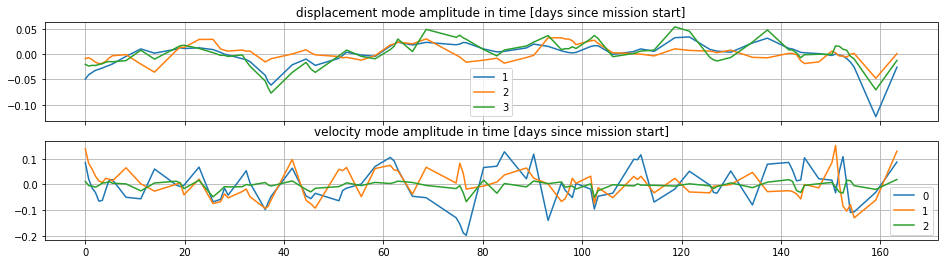

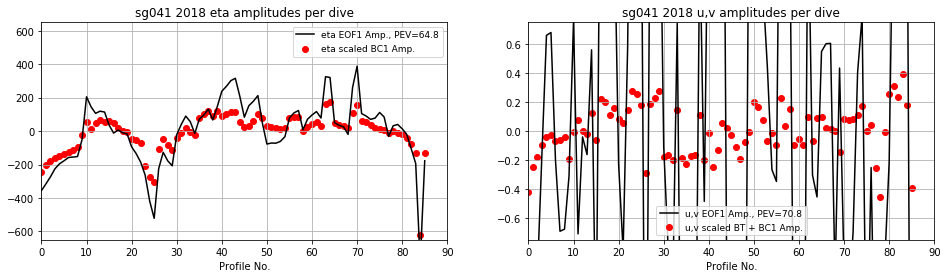

()

In [11]:
# mode amplitudes in time 
# are displacement and velocity modes correlated? 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(mw_time_good[mw_time_ordered_i] - np.nanmin(mw_time_good[mw_time_ordered_i]), AG_ordered[1, :], label='1')
ax1.plot(mw_time_good[mw_time_ordered_i] - np.nanmin(mw_time_good[mw_time_ordered_i]), AG_ordered[2, :], label='2')
ax1.plot(mw_time_good[mw_time_ordered_i] - np.nanmin(mw_time_good[mw_time_ordered_i]), AG_ordered[3, :], label='3')
ax1.set_title('displacement mode amplitude in time [days since mission start]')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.grid()
ax2.plot(mw_time_good[mw_time_ordered_i] - np.nanmin(mw_time_good[mw_time_ordered_i]), AGz_ordered[0, :], label='0')
ax2.plot(mw_time_good[mw_time_ordered_i] - np.nanmin(mw_time_good[mw_time_ordered_i]), AGz_ordered[1, :], label='1')
ax2.plot(mw_time_good[mw_time_ordered_i] - np.nanmin(mw_time_good[mw_time_ordered_i]), AGz_ordered[2, :], label='2')
ax2.set_title('velocity mode amplitude in time [days since mission start]')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)
plot_pro(ax2)

# EOF and mode amplitudes in time 
matplotlib.rcParams['figure.figsize'] = (16, 4)
f, (ax0, ax1) = plt.subplots(1, 2)
ax0.plot(np.arange(0, len(Amp1_eta)), 0.25*Amp1_eta, color='k', label='eta EOF1 Amp., PEV=' + str(np.round(frac_eof_eta[0]*100,1)))
ax0.scatter(np.arange(0, len(AG_ordered[1, :])), 5000*AG_ordered[1, :], color='r', label='eta scaled BC1 Amp.')
ax0.grid()
ax1.plot(np.arange(0, nq), Amp1_uv, color='k', label='u,v EOF1 Amp., PEV=' + str(np.round(frac_eof_uv[0]*100,1)))
ax1.scatter(np.arange(0, nq), -1.5*(AGz_ordered[1, :] + AGz_ordered[1, :]), color='r', label='u,v scaled BT + BC1 Amp.')
ax0.set_ylim([-650, 650])
ax1.set_ylim([-.75, .75])
ax2.set_ylim([-.75, .75])
ax0.set_title('sg041 2018 eta amplitudes per dive')
ax1.set_title('sg041 2018 u,v amplitudes per dive')
ax0.set_xlabel('Profile No.')
ax1.set_xlabel('Profile No.')
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=9)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=9)
ax0.set_xlim([0, 90])
ax1.set_xlim([0, 90])
plot_pro(ax1)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_09_04/sg041_eof_mode_amps.jpg", dpi=300)

In [12]:
# --- EOF of velocity profiles (for whole mission)
check1 = 7      # upper index to include in eof computation
check2 = -10     # lower index to include in eof computation
grid_check = grid[check1:check2]
V4 = mw_v_good[check1:check2, :].copy()

for i in range(np.shape(V4)[1]):
    up_avg = np.nanmean(V4[0:50, i])
    if up_avg < 0:
        V4[:, i] = -1.0 * V4[:, i]

checkk = np.zeros(np.shape(V4)[1])
for j in range(np.shape(V4)[1]):
    checkk[j] = np.sum(np.isnan(V4[:, j]))
Uzq = V4[:, checkk < 1].copy()

nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)

t1 = np.real(D_Uzqa[0:10])
PEV = t1 / np.sum(t1)

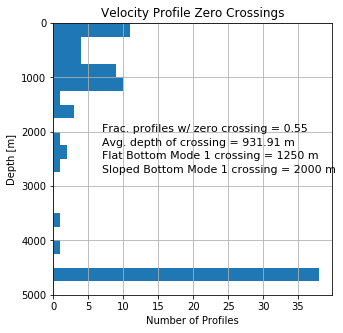

% profiles w/ zero crossing = 0.5465116279069767
Avg. depth of crossing = 931.914893617
% of profiles with negative bottom velocity = 0.453488372093


In [13]:
# look at zero crossings 
plt.rcParams['figure.figsize'] = 5, 5
first_below = grid_check[len(grid_check)-1] * np.ones(np.shape(V4)[1])
vel_sign = np.nan * np.ones(np.shape(V4)[1])
for i in range(np.shape(V4)[1]):
    fbc = V4[:, i] < 0 
    if np.sum(fbc):
        inn = grid_check[fbc]
        first_below[i] = inn[0]
        
    vel_sign[i] = np.nanmean(V4[-40:, i])      
f, ax = plt.subplots()
ax.hist(first_below, bins=range(0, 5250, 250), orientation='horizontal') 
ax.text(7, 2000, 'Frac. profiles w/ zero crossing = ' + str(np.round(len(first_below[first_below < 4000]) / len(first_below), 2)), 
        fontsize=11)
ax.text(7, 2250, 'Avg. depth of crossing = ' + str(np.round(np.nanmean(first_below[first_below < 4000]), 2)) + ' m', 
        fontsize=11)
ax.text(7, 2500, 'Flat Bottom Mode 1 crossing = 1250 m', fontsize=11)
ax.text(7, 2750, 'Sloped Bottom Mode 1 crossing = 2000 m', fontsize=11)
ax.set_ylim([0, 5000])
ax.invert_yaxis()
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Number of Profiles')
ax.set_title('Velocity Profile Zero Crossings')
plot_pro(ax)
print('% profiles w/ zero crossing = ' + str(len(first_below[first_below < 4000]) / len(first_below)))
print('Avg. depth of crossing = ' + str(np.nanmean(first_below[first_below < 4000])))
print('% of profiles with negative bottom velocity = ' + str(np.sum(vel_sign < 0) / len(vel_sign)))
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_04_18/dg_36n_zero_crossings.jpg", dpi=300)

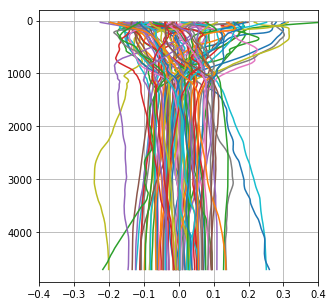

()

In [10]:
f, ax = plt.subplots()
for i in range(np.shape(Uzqa)[1]):
    ax.plot(Uzqa[:, i], grid_check)
ax.set_xlim([-.4, .4])    
ax.invert_yaxis()    
plot_pro(ax)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


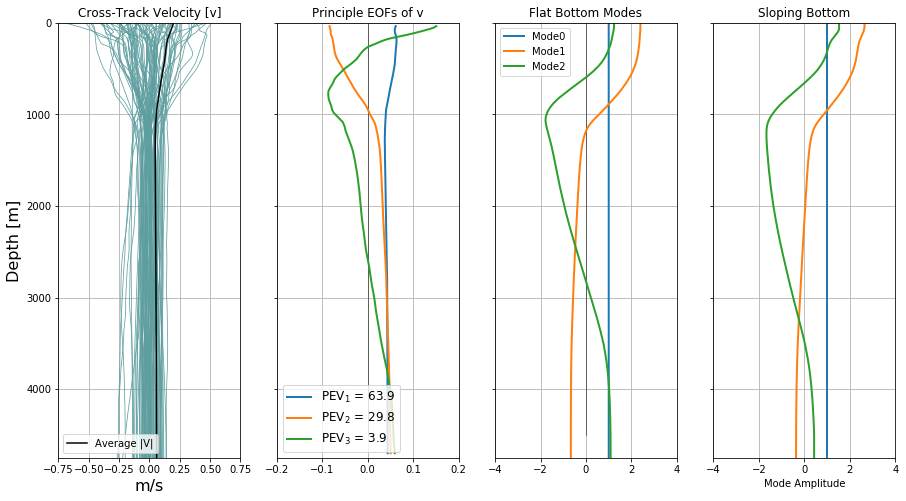

()

In [24]:
# --- plot velocity EOFs 
matplotlib.rcParams['figure.figsize'] = (15,8)
f, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(np.shape(mw_v_good)[1]):
    ax.plot(mw_v_good[:, i], grid, color='#5F9EA0', linewidth=0.75)
ax.plot(np.nanmean(np.abs(mw_v_good), axis=1), grid, color='k', label='Average |V|')
ax.set_xlim([-.75, .75])
ax.set_ylim([0, 4750])
ax.set_title('Cross-Track Velocity [v]', fontsize=12)
ax.set_xlabel('m/s', fontsize=16)
ax.set_ylabel('Depth [m]', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)

ax2.plot(np.zeros(10), np.arange(0, 5000, 500), color='k', linewidth=0.5)
ax3.plot(np.zeros(10), np.arange(0, 5000, 500), color='k', linewidth=0.5)
colorm = 'r', 'b', 'g'
for i in range(3):
    ax2.plot(V_Uzqa[:, i], grid_check, label=r'PEV$_{' + str(i + 1) + '}$ = ' + str(100 * np.round(PEV[i], 3)),
                linewidth=2)
    ax3.plot(Gz[:, i], grid, label='Mode' + str(i), linewidth=2)
    ax4.plot(F[:, i], grid, label='Mode' + str(i), linewidth=2)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=12)
ax2.set_xlim([-.2, .2])
ax2.set_title('Principle EOFs of v', fontsize=12)
# ax2.set_xlabel('m/s', fontsize=16)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=10)
ax3.set_xlim([-4, 4])
ax3.set_title('Flat Bottom Modes', fontsize=12)
# ax3.set_xlabel('[m]', fontsize=10)
ax4.set_title('Sloping Bottom', fontsize=12)
ax4.set_xlabel('Mode Amplitude', fontsize=10)
ax4.set_xlim([-4, 4])
ax.grid()
ax2.grid()
ax3.grid()
ax.invert_yaxis()
plot_pro(ax4)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/36n_v_eof_tot.jpg", dpi=300)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Optimization terminated successfully.
         Current function value: 0.013436
         Iterations: 20
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.009970
         Iterations: 8
         Function evaluations: 16
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Optimization terminated successfully.
         Current function value: 0.051396
         Iterations: 24
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: 0.508438
         Iterations: 8
         Function evaluations: 16
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Optimization terminated successfully.
         Current function value: 0.013889
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 0.033320
         Iterations: 15
         Function evaluations: 30
[ 0.  0.  0.  0.  0.  0.

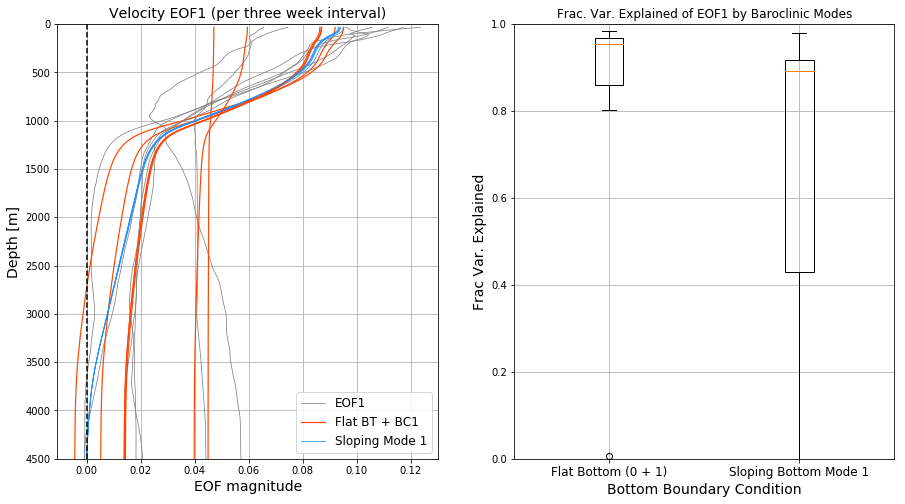

()

In [464]:
# --- EOF of velocity profiles (in two week intervals) ---
def functi_1(p, xe, xb):
    #  This is the target function that needs to be minimized
    fsq = (xe - p*xb)**2
    return fsq.sum()

def functi_2(p, xe, xb, xs):
    #  This is the target function that needs to be minimized
    fsq = (xe - (p[0] * xb + p[1] * xs)) ** 2
    # fsq = (xe - p*xb)**2
    return fsq.sum()

# loop over every two weeks (to obtain statistics)
T_week = np.arange(Time2.min(), Time2.max(), 21)
check1 = 7      # upper index to include in eof computation
check2 = -10    # lower index to include in eof computation
grid_check = grid[check1:check2]
Uzq = V2[check1:check2, :].copy()

PEV_per = np.nan * np.ones((len(T_week) - 1, 10))
fvu1_per = np.nan * np.ones(len(T_week) - 1)
fvu2_per = np.nan * np.ones(len(T_week) - 1)
bc1 = Gz[check1:check2, 0]  # flat bottom (modes 0)
bc11 = + Gz[check1:check2, 1]  # flat bottom (modes 1)
bc2 = F[check1:check2, 0]  # sloping bottom  (modes 1 + 2 ... there is no barotropic mode)
f, (ax, ax1) = plt.subplots(1, 2)
AGz_eof = np.nan * np.ones((nmodes, len(T_week) - 1))
AF_eof = np.nan * np.ones((nmodes, len(T_week) - 1))
for i in range(len(T_week) - 1):
    if i >= (len(T_week) - 2):
        V4 = Uzq[:, (Time_ordered > T_week[i])].copy()
    else:
        V4 = Uzq[:, (Time_ordered > T_week[i]) & (Time_ordered < T_week[i + 1])].copy()
    checkk = np.zeros(np.shape(V4)[1])
    for j in range(np.shape(V4)[1]):
        checkk[j] = np.sum(np.isnan(V4[:, j]))
    V4 = V4[:, checkk < 1]    
    
    print(checkk)
    nq = np.size(V4[0, :])
    avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
    Uzqa = V4 - np.transpose(np.tile(avg_Uzq, [nq, 1]))
    cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
    D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)
    t1 = np.real(D_Uzqa[0:10])
    # percent explained variance by each eof
    PEV_per[i, :] = (t1 / np.sum(t1))
    # percent variance explained of each eof by baroclinic modes with either bottom boundary condition
    eof1 = np.array(np.real(V_Uzqa[:, 0]))
    # -- minimize mode shapes onto eof shape
    p = np.array([0.8 * eof1.min() / np.max(np.abs(F[:, 0])), 0.8 * eof1.min() / np.max(np.abs(F[:, 0]))])
    p2 = 0.8 * eof1.min() / np.max(np.abs(F[:, 0]))
    ins1 = np.transpose(np.concatenate([eof1, bc1[:, np.newaxis], bc11[:, np.newaxis]], axis=1))
    ins2 = np.transpose(np.concatenate([eof1, bc2[:, np.newaxis]], axis=1))
    min_p1 = fmin(functi_2, p, args=(tuple(ins1)))
    min_p2 = fmin(functi_1, p2, args=(tuple(ins2)))
    fvu1_per[i] = 1 - (np.sum((eof1[:, 0] - (bc1 * min_p1[0] + bc11 * min_p1[1])) ** 2) /
                    np.sum((eof1 - np.mean(eof1)) ** 2))
    fvu2_per[i] = 1 - (np.sum((eof1[:, 0] - bc2 * min_p2) ** 2) / np.sum((eof1 - np.mean(eof1)) ** 2))

    if np.nanmean(bc1[0:6] * min_p1[0] + bc11[0:6] * min_p1[1]) < 0:  # np.nanmean(eof1[0:20] < 0):
        if fvu1_per[i] > 0:
            ax.plot(-1 * eof1, grid_check, color='#808080', linewidth=0.75, label='EOF1')
            ax.plot(-1 * (bc1 * min_p1[0] + bc11 * min_p1[1]), grid_check, color='#FF4500', linewidth=1.2, label='Flat BT + BC1')
        if fvu2_per[i] > 0:
            ax.plot(-1 * bc2 * min_p2, grid_check, color='#1E90FF', linewidth=0.75, label='Sloping Mode 1')
    else:
        if fvu1_per[i] > 0:
            ax.plot(eof1, grid_check, color='#808080', linewidth=0.75, label='EOF1')
            ax.plot((bc1 * min_p1[0] + bc11 * min_p1[1]), grid_check, color='#FF4500', linewidth=1.2, label='Flat BT + BC1')
        if fvu2_per[i] > 0:
            ax.plot(bc2 * min_p2, grid_check, color='#1E90FF', linewidth=0.75, label='Sloping Mode 1')
ax.plot([0, 0], [0, 4500], color='k', linestyle='--')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[1], handles[2]], [labels[0], labels[1], labels[2]], fontsize=12)
ax.set_title('Velocity EOF1 (per three week interval)', fontsize=14)
ax.set_ylabel('Depth [m]', fontsize=14)
ax.set_xlabel('EOF magnitude', fontsize=14)
ax.set_ylim([0, 4500])
ax.invert_yaxis()

fvu1_per[fvu1_per < 0] = 0.
fvu2_per[fvu2_per < 0] = 0.

ax1.boxplot([fvu1_per[~np.isnan(fvu1_per)], fvu2_per[~np.isnan(fvu2_per)]])  # fvu1_per[:, None]
ax1.set_ylim([0, 1])
ax1.set_title('Frac. Var. Explained of EOF1 by Baroclinic Modes')
ax1.set_xlabel('Bottom Boundary Condition', fontsize=14)
ax1.set_ylabel('Frac Var. Explained', fontsize=14)
ax1.set_xticklabels(['Flat Bottom (0 + 1)', 'Sloping Bottom Mode 1'], fontsize=12)
# ax2.set_title('Bottom Boundary Condition')
# ax2.set_ylabel('Frac Var. Explained by Mode Shapes')
# ax2.set_ylim([0, 1])
ax.grid()
plot_pro(ax1)

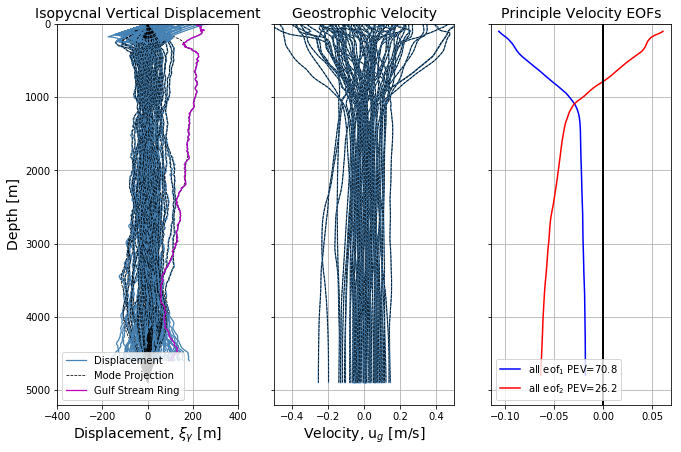

In [27]:
# plot eta 
edd = np.where(np.abs(mw_eta_3_good[100, :]) > 175)[0]

# plt.rcParams['figure.figsize'] = 15, 10
# f_eta, (ax1, ax0) = plt.subplots(1, 2, sharey=True)
# pzmax = -5
# for j in range(num_profs):
#     ax1.plot(mw_eta_3_good[0:pzmax, j], grid[0:pzmax], color='#4682B4', linewidth=1.25)
#     ax1.plot(Eta_m[:, j], grid, color='k', linestyle='--', linewidth=.75)
#     if good_ke_prof[j] > 0:
#         ax0.plot(mw_v_good[:, j], grid, color='#4682B4', linewidth=1.25)
#         ax0.plot(V_m[:, j], grid, color='k', linestyle='--', linewidth=.75)
# ax1.plot(mw_eta_3_good[0:pzmax, edd], grid[0:pzmax], color='m', linewidth=1.25)
# ax1.set_xlim([-400, 400]) 
# ax1.set_ylim([0, 5100])
# ax1.invert_yaxis()
# ax1.grid()
# ax0.set_xlim([-.5, .5])
# ax0.set_title("Geostrophic Velocity", fontsize=11)  # (" + str(num_profs) + 'profiles)' )
# ax0.set_xlabel('Cross-Track Velocity, U [m/s]', fontsize=11)
# ax1.set_xlabel(r'Vertical Isopycnal Displacement, $\xi_{\gamma}$ [m]', fontsize=11)
# ax1.set_title(r'Isopycnal Displacement (Avg.)', fontsize=11)
# ax1.set_ylabel('Depth [m]', fontsize=11)
# plot_pro(ax0)   

matplotlib.rcParams['figure.figsize'] = (11,7)
f_eta, (ax1, ax0, ax2) = plt.subplots(1, 3, sharey=True)
pzmax = -15
ax1.plot(mw_eta_3_good[0:pzmax, 0], grid[0:pzmax], color='#4682B4', linewidth=1.25, label='Displacement')
ax1.plot(Eta_m[:, 0], grid, color='k', linestyle='--', linewidth=.75, label='Mode Projection')
ax0.plot(mw_v_good[:, 0], grid, color='#4682B4', linewidth=1.25, label='Velcocity')
ax0.plot(V_m[:, 0], grid, color='k', linestyle='--', linewidth=.75, label='Mode Projection')
for j in range(num_profs):
    ax1.plot(mw_eta_3_good[0:pzmax, j], grid[0:pzmax], color='#4682B4', linewidth=1.25)
    ax1.plot(Eta_m[:, j], grid, color='k', linestyle='--', linewidth=.75)
    if good_ke_prof[j] > 0:
        ax0.plot(mw_v_good[:, j], grid, color='#4682B4', linewidth=1.25)
        ax0.plot(V_m[:, j], grid, color='k', linestyle='--', linewidth=.75)

ax1.plot(mw_eta_3_good[0:pzmax, edd], grid[0:pzmax], color='m', linewidth=1.25, label='Gulf Stream Ring')        
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
# ax0.text(150, 4500, str(num_profs) + ' Profiles')
ax1.set_xlim([-400, 400]) 
ax1.set_ylim([0, 5200])
ax1.invert_yaxis()
ax1.grid()
ax0.set_xlim([-.5, .5])
ax0.set_title("Geostrophic Velocity", fontsize=14)  # (" + str(num_profs) + 'profiles)' )
ax0.set_xlabel(r'Velocity, u$_g$ [m/s]', fontsize=14)
ax1.set_xlabel(r'Displacement, $\xi_{\gamma}$ [m]', fontsize=14)
ax1.set_title(r'Isopycnal Vertical Displacement', fontsize=14)
ax1.set_ylabel('Depth [m]', fontsize=14)
ax0.grid()

mo_col = 'b', 'r' ,'k'
ax2.plot(UU3[:, 0], grid[grid_sub_i_2], label=r'all eof$_1$ PEV=' + str(np.round(frac_eof_uv[0]*100,1)), color='b')
ax2.plot(UU3[:, 1], grid[grid_sub_i_2], label=r'all eof$_2$ PEV=' + str(np.round(frac_eof_uv[1]*100,1)), color='r')
ax2.plot([0, 0], [0, 5500], color='k', linewidth=2)
ax2.set_title('Principle Velocity EOFs', fontsize=14)
# ax2.set_xlabel('EOF magnitude', fontsize=14)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)
    
plot_pro(ax2)    
f_eta.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_36n_18_eta_v_eof.jpg", dpi=300)

In [60]:
# Mode Amplitude Correlations 
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (prof_lon_i - ref_lon)
y = 1852 * 60 * (prof_lat_i - ref_lat)
x_tile = np.tile(x, (len(x), 1))
y_tile = np.tile(y, (len(y), 1))
time_tile = np.tile(time_rec_bin, (len(time_rec_bin), 1))
dist = np.sqrt((x_tile - x_tile.T) ** 2 + (y_tile - y_tile.T) ** 2) / 1000
time_lag = np.abs(time_tile - time_tile.T)

# redo with only zonal separation
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (prof_lon_i - ref_lon) / 1000
y = 1852 * 60 * (prof_lat_i - ref_lat) / 1000
t = time_rec_bin.copy()
AG_i = AG_all[1, :]
AG_ii = AG_all[3, :]

# distances apart
# dist_x = np.nan * np.zeros((len(x), len(x)))
# time_l = np.nan * np.zeros((len(x), len(x)))
for i in range(len(x) - 1):
    if i < 1:
        dist_x = x[i+1:] - x[i]
        dist_y = y[i+1:] - y[i]
        dist_t = np.sqrt(dist_x**2 + dist_y**2)
        time_l = np.abs(time_rec_bin[i] - t[i+1:])
        AG_count = np.array((AG_i[i] * np.ones(len(x[i+1:])), AG_i[i+1:]))
        AG_count2 = np.array((AG_ii[i] * np.ones(len(x[i + 1:])), AG_ii[i + 1:]))
    else:
        dist_x = np.concatenate((dist_x, x[i+1:] - x[i]))
        dist_y = np.concatenate((dist_y, y[i + 1:] - y[i]))
        dist_t = np.concatenate((dist_t, np.sqrt((x[i+1:] - x[i])**2 + (y[i + 1:] - y[i])**2)))
        time_l = np.concatenate((time_l, np.abs(t[i] - t[i+1:])))
        AG_count = np.concatenate((AG_count, np.array((AG_i[i] * np.ones(len(x[i + 1:])), AG_i[i + 1:]))), axis=1)
        AG_count2 = np.concatenate((AG_count2, 
                                    np.array((AG_ii[i] * np.ones(len(x[i + 1:])), AG_ii[i + 1:]))), axis=1)
        
# define each box as all points that fall within a time and space lag
dist_win = np.arange(-100, 105, 2)
dist_t_win = np.arange(0, 105, 5)
t_win = np.arange(0, 80, 2)
t_t_win = np.arange(0, 80, 5)
corr_i_z = np.nan * np.zeros((len(t_win), len(dist_win)))
corr_i_z2 = np.nan * np.zeros((len(t_win), len(dist_win)))
corr_i_all = np.nan * np.zeros((len(t_t_win), len(dist_t_win)))
for dd in range(len(dist_win) - 1):
    for tt in range(len(t_win) - 1):
        in_box = np.where((dist_x > dist_win[dd]) & (dist_x < dist_win[dd + 1]) & 
                          (time_l > t_win[tt]) & (time_l < t_win[tt + 1]))[0]
        if len(in_box) > 4:
            inski_with = AG_count[:, in_box]
            inski = np.unique(AG_count[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(len(inski))
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_z[tt, dd] = (1 / (n * variance)) * np.nansum(covi)

            inski_with = AG_count2[:, in_box]
            inski = np.unique(AG_count2[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(np.shape(inski_with)[1])
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_z2[tt, dd] = (1 / (n * variance)) * np.nansum(covi)   
            
for dd in range(len(dist_t_win) - 1):
    for tt in range(len(t_t_win) - 1):
        in_box = np.where((dist_t > dist_t_win[dd]) & (dist_t < dist_t_win[dd + 1]) &
                            (time_l > t_t_win[tt]) & (time_l < t_t_win[tt + 1]))[0]
        if len(in_box) > 5:
            inski_with = AG_count[:, in_box]
            inski = np.unique(AG_count[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(np.shape(inski_with)[1])
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_all[tt, dd] = (1 / (n * variance)) * np.nansum(covi)    
            
f, (ax1, ax2) = plt.subplots(1, 2)
pa = ax1.pcolor(dist_win, t_win, corr_i_z, vmin=-1, vmax=.8, cmap='jet')
pa2 = ax2.pcolor(dist_win, t_win, corr_i_z2, vmin=-1, vmax=.8, cmap='jet')
ax1.set_xlabel('Zonal Separation [km]')
ax1.set_ylabel('Time Lag [days]')
ax2.set_xlabel('Zonal Separation [km]')
ax1.set_title('Displacement Mode 1 Amplitude')
ax2.set_title('Displacement Mode 3 Amplitude')
f.colorbar(pa, ax=ax1, label='Correlation')
f.colorbar(pa2, ax=ax2, label='Correlation')
ax1.grid()
plot_pro(ax2)

f, ax1 = plt.subplots()
pa = ax1.pcolor(dist_t_win, t_t_win, corr_i_all, vmin=-1, vmax=1, cmap='jet')
ax1.set_xlabel('Spatial Separation [km]')
ax1.set_ylabel('Time Lag [days]')
ax1.set_title('Displacement Mode 1 Amplitude')
plt.colorbar(pa, label='Correlation')
plot_pro(ax1)       

NameError: name 'prof_lon_i' is not defined

In [111]:
mw_prof_good

array([ 174.5,   71.5,   86.5,   87. ,   87.5,   99.5,  116.5,  134.5,
        145.5,  156.5,   69.5,   83.5,   84. ,   84.5,   96.5,   97. ,
         97.5,  112.5,  113. ,  113.5,  114. ,  131.5,  132. ,  132.5,
        143.5,  154.5,  171.5,   67.5,   79.5,   80.5,   81. ,   81.5,
        101.5,  108.5,  118.5,  119.5,  127.5,  128. ,  128.5,  129. ,
        129.5,  165.5,  166. ,  166.5,  167. ,  167.5,  168. ,  168.5,
         61.5,   62. ,   62.5,   63. ,   63.5,   64. ,   64.5,   65. ,
         65.5,   77.5,   92.5,   93. ,   93.5,  106.5,  125.5,  140.5,
        151.5,  163.5,   74.5,   75. ,   75.5,   90.5,  103.5,  104. ,
        104.5,  122.5,  123.5,  137.5,  138. ,  138.5,  148.5,  149. ,
        149.5,  159.5,  160. ,  160.5,  161. ,  161.5])

In [15]:
# ----------------------------------------------------------------------------------------------------------------------
# --- ENERGY SPECTRA ---
# ----------------------------------------------------------------------------------------------------------------------
# -- initial params
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
dk = f_ref / c_tot[1]
sc_x = 1000 * f_ref / c_tot[1:]

# --- PE, KE selection (exclude eddy)
HKE_per_mass_0 = HKE_per_mass.copy()
PE_per_mass_0 = PE_per_mass.copy()
# HKE_per_mass = HKE_per_mass[:, np.where(good_ke_prof > 0)[0]]
# PE_per_mass = PE_per_mass[:, np.where(good_ke_prof > 0)[0]]
used_profiles = mw_prof_good[good_ke_prof > 0]
calmer = np.where((mw_prof_good < 60) | (mw_prof_good >= 71) & (good_ke_prof > 0))[0]  # excl. labby
# calmer = np.arange(0, np.int(np.sum(good_ke_prof)))
avg_PE = np.nanmean(PE_per_mass[:, calmer], 1)
avg_KE = np.nanmean(HKE_per_mass[:, calmer], 1)

# --- ENERGY parameters ---
vert_wavenumber = f_ref / c[1:]
dk_ke = 1000 * f_ref / c[1]
k_h = 1e3 * (f_ref / c[1:]) * np.sqrt(avg_KE[1:] / avg_PE[1:])
PE_SD, PE_GM, GMPE, GMKE, n2_decay_sc = PE_Tide_GM(rho0, grid, nmodes, np.transpose(np.atleast_2d(np.nanmean(N2, axis=1))), f_ref)
vert_wave = sc_x / 1000
alpha = 10
mu = 1.88e-3 / (1 + 0.03222 * np.nanmean(theta_avg, axis=1) +
                0.002377 * np.nanmean(theta_avg, axis=1) * np.nanmean(theta_avg, axis=1))
nu = mu / gsw.rho(np.nanmean(sa_avg, axis=1), np.nanmean(ct_avg, axis=1), grid_p)
avg_nu = np.nanmean(nu)


# --- most and least energetic profiles
KE_i = HKE_per_mass[:, calmer]
PE_i = PE_per_mass[:, calmer]
KE_it = np.nan * np.ones(KE_i.shape[1])
PE_it = np.nan * np.ones(KE_i.shape[1])
for i in range(KE_i.shape[1]):
    KE_it[i] = np.trapz(KE_i[1:, i] + PE_i[1:, i], 1000 * f_ref / c[1:])
    PE_it[i] = np.trapz(PE_i[1:, i], 1000 * f_ref / c[1:])
KE_i_max = np.where(KE_it == np.nanmax(KE_it))[0]
KE_i_min = np.where(KE_it == np.nanmin(KE_it))[0]
PE_i_max = np.where(PE_it == np.nanmax(PE_it))[0]
PE_i_min = np.where(PE_it == np.nanmin(PE_it))[0]
k_h_max = 1e3 * (f_ref / c[1:]) * np.sqrt(np.squeeze(KE_i[1:, KE_i_max]) / np.squeeze(PE_i[1:, KE_i_max]))
k_h_min = 1e3 * (f_ref / c[1:]) * np.sqrt(np.squeeze(KE_i[1:, KE_i_min]) / np.squeeze(PE_i[1:, KE_i_min]))

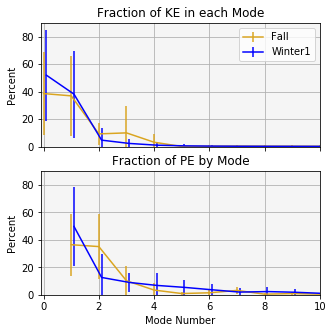

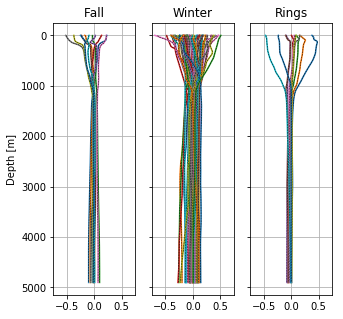

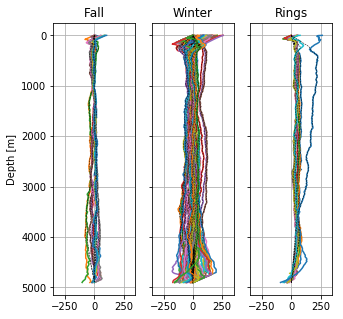

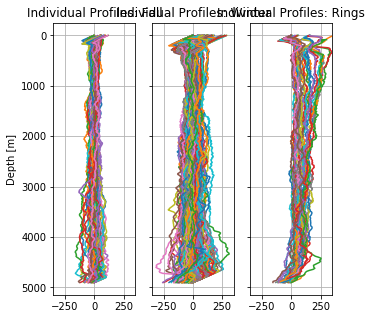

()

In [16]:
# --- Partition KE, PE by season (like bats) ---

# fall
d_fall = np.where((Time_ordered <= bd1) & ((Info3 < 54) | (Info3 > 66.9)))[0]
# Winter1
d_win1 = np.where((Time_ordered > bd1) & (Time_ordered < bd2))[0]
# Winter2
d_win2 = np.where((Time_ordered > bd1) & (Time_ordered < bd3) & ((Info3 < 168) | (Info3 >= 174)))[0]
# Rings
d_ring = np.where( ((Info3 > 54) & (Info3 < 66.9)) | ((Info3 > 168) & (Info3 < 174)) )[0]
# combine
bckgrds = [d_fall, d_win2, d_ring]  # KEY!! 4, sets of profiles
bckgrds_key = 'Fall', 'Winter', 'Rings'
k_h_fall = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[0]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[0]], axis=1))
k_h_win1 = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[1]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[1]], axis=1))
# k_h_win2 = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[2]], axis=1) /
#                                            np.nanmean(PE_per_mass_0[1:, bckgrds[2]], axis=1))

# --- RATIO of KE_i / KE_total
KE_fraction_f = 100 * HKE_per_mass_0[:, bckgrds[0]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[0]],
                                                                         axis=0), (nmodes, 1))
KE_fraction_w1 = 100 * HKE_per_mass_0[:, bckgrds[1]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[1]],
                                                                         axis=0), (nmodes, 1))
# KE_fraction_w2 = 100 * HKE_per_mass_0[:, bckgrds[2]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[2]],
#                                                                          axis=0), (nmodes, 1))
PE_fraction_f = 100 * PE_per_mass_0[:, bckgrds[0]] / np.tile(np.nansum(PE_per_mass_0[:, bckgrds[0]],
                                                                        axis=0), (nmodes, 1))
PE_fraction_w1 = 100 * PE_per_mass_0[:, bckgrds[1]] / np.tile(np.nansum(PE_per_mass_0[:, bckgrds[1]],
                                                                        axis=0), (nmodes, 1))
# PE_fraction_w2 = 100 * PE_per_mass_0[:, bckgrds[2]] / np.tile(np.nansum(PE_per_mass_0[:, bckgrds[2]],
#                                                                         axis=0), (nmodes, 1))

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_facecolor('#F5F5F5')
ax1.errorbar(np.arange(0, nmodes), np.nanmean(KE_fraction_f, axis=1), yerr=np.nanstd(KE_fraction_f, axis=1), label='Fall', color=cols[0])
ax1.errorbar(np.arange(0, nmodes) + .1, np.nanmean(KE_fraction_w1, axis=1), yerr=np.nanstd(KE_fraction_w1, axis=1), label='Winter1', color=cols[1])
# ax1.errorbar(np.arange(0, nmodes) + .2, np.nanmean(KE_fraction_w2, axis=1), yerr=np.nanstd(KE_fraction_w2, axis=1), label='Winter2', color=cols[2])
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.set_ylim([0, 90])
ax1.set_xlim([-.1, 10])
ax1.set_title('Fraction of KE in each Mode')
ax1.set_ylabel('Percent')
ax1.grid()
ax2.set_facecolor('#F5F5F5')
ax2.errorbar(np.arange(1, nmodes), np.nanmean(PE_fraction_f[1:, :], axis=1), yerr=np.nanstd(PE_fraction_f[1:, :], axis=1), color=cols[0])
ax2.errorbar(np.arange(1, nmodes) + .1, np.nanmean(PE_fraction_w1[1:, :], axis=1), yerr=np.nanstd(PE_fraction_w1[1:, :], axis=1), color=cols[1])
# ax2.errorbar(np.arange(1, nmodes) + .2, np.nanmean(PE_fraction_w2[1:, :], axis=1), yerr=np.nanstd(PE_fraction_w2[1:, :], axis=1), color=cols[2])
ax2.set_ylim([0, 90])
ax2.set_title('Fraction of PE by Mode')
ax2.set_ylabel('Percent')
ax2.set_xlabel('Mode Number')
plot_pro(ax2)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_04_18/dg_36n_energy_fracs.jpg", dpi=300)



# velocity profiles by season 
f, ax = plt.subplots(1, len(bckgrds), sharey=True)
for i in range(len(bckgrds)):
    vin = V_ordered[:, bckgrds[i]]
    vin_m = Vm_ordered[:, bckgrds[i]]
    for j in range(np.shape(V_ordered[:, bckgrds[i]])[1]):
        ax[i].plot(vin[:, j], grid)
        ax[i].plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
    ax[i].set_xlim([-0.75, 0.75])
    ax[i].set_title(bckgrds_key[i])
ax[0].set_ylabel('Depth [m]')
ax[0].grid()
ax[1].grid()
ax[0].invert_yaxis()
plot_pro(ax[2])
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_04_18/dg_36n_v_seasonal.jpg", dpi=300)


# displacement profiles by season 
f, ax = plt.subplots(1, len(bckgrds), sharey=True)
for i in range(len(bckgrds)):
    vin = Eta_ordered[:, bckgrds[i]]
    vin_m = Etam_ordered[:, bckgrds[i]]
    for j in range(np.shape(V_ordered[:, bckgrds[i]])[1]):
        ax[i].plot(vin[:, j], grid)
        ax[i].plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
    ax[i].set_xlim([-350, 350])
    ax[i].set_title(bckgrds_key[i])
ax[0].set_ylabel('Depth [m]')    
ax[0].grid()
ax[1].grid()
ax[0].invert_yaxis()
plot_pro(ax[2])
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_04_18/dg_36n_eta_seasonal.jpg", dpi=300)

# individual seasonal profiles of eta 
# fall
d_f_ind = np.where((prof_time <= bd1) & ((profile_tags < 54) | (profile_tags > 66.9)))[0]
# Winter1
d_w1_ind = np.where((prof_time > bd1) & (prof_time < bd2))[0]
# Winter2
d_w2_ind = np.where((prof_time > bd1) & (prof_time < bd3) & ((profile_tags < 168) | (profile_tags >= 174)))[0]
# Rings
d_ring_ind = np.where( ((profile_tags > 54) & (profile_tags < 66.9)) | ((profile_tags > 168) & (profile_tags < 174)) ) 
bckgrds_ind = [d_f_ind, d_w2_ind, d_ring_ind]
# ind displacement profiles by season 
f, ax = plt.subplots(1, len(bckgrds_ind), sharey=True)
for i in range(len(bckgrds_ind)):
    vin = eta_ind_3[:, bckgrds_ind[i]]
    for j in range(np.shape(vin)[1]):
        ax[i].plot(vin[:, j], grid)
    ax[i].set_xlim([-350, 350])
    ax[i].set_title('Individual Profiles: ' + bckgrds_key[i])
ax[0].set_ylabel('Depth [m]')    
ax[0].grid()
ax[1].grid()
ax[0].invert_yaxis()
plot_pro(ax[2])
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_04_18/dg_36n_eta_ind_seasonal.jpg", dpi=300)

In [72]:
print(np.nanmean(PE_fraction_f[0:4], axis=1))
print(np.nanmean(PE_fraction_w1[0:4], axis=1))
print(np.sum(np.nanmean(PE_fraction_f[0:4], axis=1)))
print(np.sum(np.nanmean(PE_fraction_w1[0:4], axis=1)))

[  0.          36.49267083  35.12607936  10.22152911]
[  0.          49.82423976  12.64121178   9.02642557]
81.8402792957
71.4918771088


In [17]:
# --- find break for average profile (total) ---
inn = bckgrds[2]
TE_spectrum = (np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk ) + (np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk)
in_sp = np.transpose(np.concatenate([sc_x[:, np.newaxis], TE_spectrum[:, np.newaxis]], axis=1))
start_g = sc_x[1]
min_sp_avg = fmin(spectrum_fit, start_g, args=(tuple(in_sp)))
this_TE = TE_spectrum 
x = np.log10(sc_x)
pe = np.log10(this_TE)
mid_p = np.log10(min_sp_avg)
l_b = np.nanmin(x)
r_b = np.nanmax(x)
x_grid = np.arange(l_b, r_b, 0.01)
pe_grid = np.interp(x_grid, x, pe)
first_over = np.where(x_grid > mid_p)[0][0]
s1 = -5 / 3
b1 = pe_grid[first_over] - s1 * x_grid[first_over]
fit_53 = np.polyval(np.array([s1, b1]), x_grid[0:first_over + 1])
s2 = -3
b2 = pe_grid[first_over] - s2 * x_grid[first_over]
fit_3 = np.polyval(np.array([s2, b2]), x_grid[first_over:])
fit_total = np.concatenate((fit_53[0:-1], fit_3))
# - closest mode number to ak0
sc_x_break_i = np.where(sc_x < min_sp_avg)[0][-1]

# --- cascade rates (for average TE spectrum) ---
ak0 = min_sp_avg / 1000  # xx[ipoint] / 1000
E0 = np.interp(ak0 * 1000, sc_x, TE_spectrum)  # np.mean(yy_tot[ipoint - 3:ipoint + 4])
ak = vert_wave / ak0
one = E0 * ((ak ** (5 * alpha / 3)) * (1 + ak ** (4 * alpha / 3))) ** (-1 / alpha)
# ---  enstrophy/energy transfers
enst_xfer = (E0 * ak0 ** 3) ** (3 / 2)
ener_xfer = (E0 * ak0 ** (5 / 3)) ** (3 / 2)
enst_diss = np.sqrt(avg_nu) / (enst_xfer ** (1 / 6))
rms_vort = E0 * (ak0 **3) * (0.75*(1 - (sc_x[0] / 1000)/ak0)**(4/3) + np.log(enst_diss / ak0))
rms_ener = E0 * (ak0) * ( -3/2 + 3/2*( (ak0 ** (2/3))*((sc_x[0] / 1000) ** (-2/3))) -
                          0.5 * (ak0 ** 2) * (enst_diss ** -2) + 0.5 * ak0 ** 4)

Optimization terminated successfully.
         Current function value: 280548.200333
         Iterations: 10
         Function evaluations: 23


In [126]:
print('enstrophy dissipation length = ' + str(enst_diss))
print('RMS vorticity rossby no = ' + str(np.sqrt(rms_vort) / f_ref))

enstrophy dissipation length = [ 0.66258062]
RMS vorticity rossby no = [ 0.1098869]


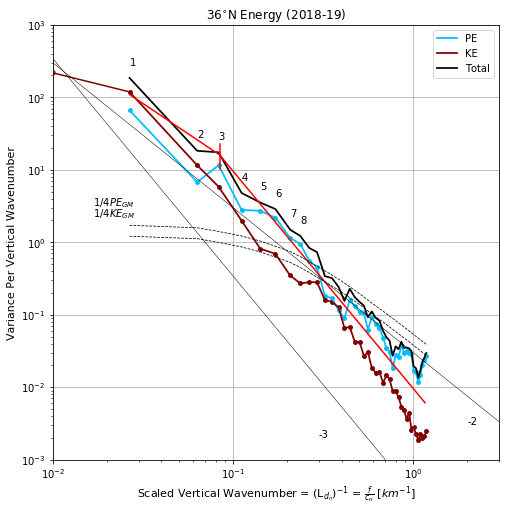

()

In [18]:
# --- PLOT ENERGY

matplotlib.rcParams['figure.figsize'] = (8,8)

scols = ['#00BFFF', '#800000']

f_s_en, ax1 = plt.subplots()
labs = 'Oct15-Nov30 (' + str(np.shape(d_fall)[0]) + ' profiles)', 'Nov30-Apr15 (' + str(np.shape(d_win2)[0]) + ' profiles)', 'Rings'
lw = [1.75, 1.75, 1.75, .8]
scz = [15, 15, 15, 6]
seasonal_PE_output = np.nan * np.ones((nmodes, len(bckgrds)))
seasonal_KE_output = np.nan * np.ones((nmodes, len(bckgrds)))
for i in range(1, 2):  # len(bckgrds)
    inn = bckgrds[1]  # range(0, np.shape(PE_per_mass_0)[1])
    ax1.plot(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=scols[0], label='PE', linewidth=lw[i])
    ax1.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=scols[0], s=scz[i])
    ax1.plot(sc_x, np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=scols[1], label='KE', linewidth=lw[i])
    ax1.scatter(sc_x, np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=scols[1], s=scz[i])
    ax1.plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0:2] / dk, color=scols[1], linewidth=1.5)
    ax1.scatter(10**-2, np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0] / dk, color=scols[1], s=scz[i]*1.5, facecolors='none')
    # plot PE from individual profiles if wanted
    # ax1.plot(sc_x, np.nanmean(PE_per_mass_all[1:, bckgrds_all[i]], axis=1) / dk, color=cols[i], label=labs[i], linewidth=1, linestyle='-')
    # ax1.scatter(sc_x, np.nanmean(PE_per_mass_all[1:, bckgrds_all[i]], axis=1) / dk, color=cols[i], s=15)   
    
    ax1.plot(sc_x, (np.nanmean(PE_per_mass_0[1:, inn], axis=1) + np.nanmean(HKE_per_mass_0[1:, inn], axis=1)) / dk, 
             color='k', label='Total', linewidth=lw[i])
    
    ax1.plot(10**x_grid, 10**fit_total, color='r')
    ax1.plot(10**np.array([x_grid[first_over], x_grid[first_over]]), 
             10**np.array([fit_3[0]-.2, fit_3[0]+.15]), color='r')
    
    seasonal_PE_output[1:, i] = np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk
    seasonal_KE_output[1:, i] = np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk
    seasonal_KE_output[0, i] = np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0] / dk
inn = bckgrds[1]    
TEE = (np.nanmean(PE_per_mass_0[1:, inn], axis=1) + np.nanmean(HKE_per_mass_0[1:, inn], axis=1)) / dk    
modeno = '1', '2', '3', '4', '5', '6', '7', '8'   
for i in range(len(modeno)):
    ax1.text(sc_x[i], TEE[i] + (TEE[i]/2), modeno[i], color='k', fontsize=10)     
# -- GM
ax1.plot(1000 * f_ref / c_tot[1:], 0.25 * PE_GM / dk, color='k', linewidth=0.75, linestyle='--')
ax1.text(1000 * f_ref / c_tot[1] - .01, 0.5 * PE_GM[1] / dk, r'$1/4 PE_{GM}$', fontsize=10)
ax1.plot(1000 * f_ref / c_tot[1:], 0.25 * GMKE / dk, color='k', linewidth=0.75, linestyle='--')
ax1.text(1000 * f_ref / c_tot[1] - .01, 0.5 * GMKE[1] / dk, r'$1/4 KE_{GM}$', fontsize=10)    
ax1.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax1.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax1.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax1.text(2*10**0, 3*10**-3, '-2', fontsize=10)
# ax2.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
# ax2.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
# ax2.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
# ax2.text(2*10**0, 3*10**-3, '-2', fontsize=10)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=11)
ax1.set_ylabel('Variance Per Vertical Wavenumber', fontsize=11)
ax1.set_title(r'36$^{\circ}$N Energy (2018-19)')
ax1.set_xlim([10 ** -2, 3 * 10 ** 0])
ax1.set_ylim([10 ** (-3), 1 * 10 ** 3])
ax1.set_yscale('log')
ax1.set_xscale('log')
# ax2.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=11)
# ax2.set_title('Kinetic Energy')
# ax2.set_xlim([10 ** -2, 3 * 10 ** 0])
# ax2.set_xscale('log')
plot_pro(ax1)
# f_s_en.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_04_18/dg_36n_ring_energy.jpg", dpi=300)

In [19]:
# surface kinetic energy 
# temporal orthogonality of the modes 
L = len(AGz_ordered[0, :])
mm = np.nan * np.ones((L, len(grid), np.shape(AGz_ordered)[0]))
mm2 = np.nan * np.ones((L, len(grid), np.shape(AGz_ordered)[0]))
for j in range(L):  # loop over each time 
    for i in range(np.shape(AGz_ordered)[0]):  # loop over each mode 
        mm[j, :, i] = AGz_ordered[i, j]*Gz[:, i]
        mm2[j, :, i] = (AGz_ordered[i, j]**2)*(Gz[:, i]**2)
    
# outer mean is avg across time ( inner sum is acoss modes)    
T_1 = np.nanmean(np.squeeze(np.nansum(mm, axis=2)**2), axis=0) 
# outer mean is avg across time
T_2 = np.nanmean(mm2, axis=0)
T_2_check = np.nanmean(np.nansum(mm2, axis=2), axis=0)

In [36]:
np.shape(T_2)
np.shape(AGz_ordered)[0]

41

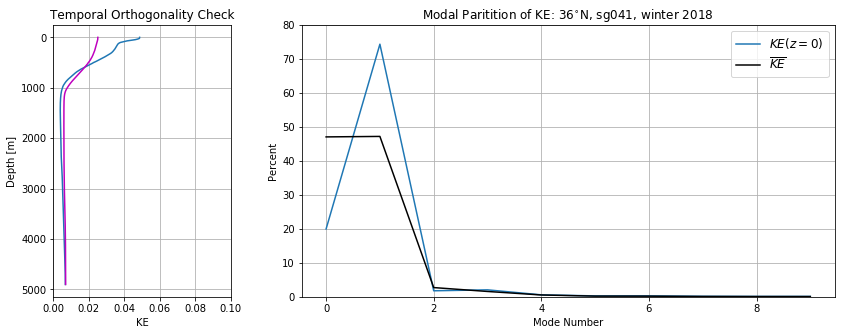

In [39]:
from matplotlib import gridspec
fig0 = plt.figure(figsize=(14, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
ax0 = plt.subplot(gs[0])
ax = plt.subplot(gs[1])

ax0.plot(T_1, grid)
ax0.plot(T_2_check, grid, color='m')
ax0.set_xlim([0, 0.1])
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('KE')
ax0.set_title('Temporal Orthogonality Check')
ax0.invert_yaxis()
ax0.grid()

ax.plot(np.arange(0, 10), 100*T_2[0, 0:10]/np.nansum(T_2[0, :]), label=r'$KE(z=0)$')
T_2_mean = np.nanmean(T_2, axis=0)
ax.plot(np.arange(0, 10), 100*(T_2_mean[0:10]/np.nansum(T_2_mean)), color='k', label=r'$\overline{KE}$')
ax.set_xlabel('Mode Number')
ax.set_ylabel('Percent')
ax.set_title('Modal Paritition of KE: 36$^{\circ}$N, sg041, winter 2018')
ax.set_ylim([0, 80])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12)
plot_pro(ax)
fig0.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_36n_18_surface_ke.jpg", dpi=300)

In [16]:
sa = 1
if sa > 0:
    my_dict = {'depth': grid, 'KE': avg_KE, 'PE': avg_PE, 'c': c, 'f': f_ref, 'N2_per': N2,
               'PE_all': PE_per_mass_0, 'PE_per_prof_all': PE_per_prof, 'KE_all': HKE_per_mass_0,
               'background_eddy_indicies_for_energy': bckgrds, 'GMPE': GMPE, 'GMKE': GMKE,
               'epsilons_per_season': epsilons, 'season_key': bckgrds_key}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg041_2018_energy_june_4_2019.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()

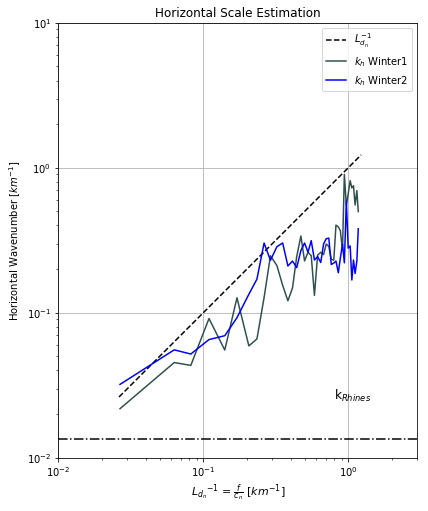

In [73]:
# Rhines Scale 
r_earth = 6371e3  # earth radius [m]
beta_ref = f_ref / (np.tan(np.deg2rad(ref_lat)) * r_earth)
K_beta_2 = 1 / np.sqrt(np.sqrt(np.nanmean(V2**2)) / beta_ref)

matplotlib.rcParams['figure.figsize'] = (16,8)
fig_special, ax2 = plt.subplots()

ax2.plot([1000 * f_ref / c[1], 1000 * f_ref / c[-2]], [1000 * f_ref / c[1], 1000 * f_ref / c[-2]], linestyle='--',
            color='k', linewidth=1.5, zorder=2, label=r'$L_{d_n}^{-1}$')
ax2.plot(sc_x, k_h_win1, color=cols[1], label=r'$k_h$ Winter1', linewidth=1.5)
# ax2.plot(sc_x, k_h_sum, color=cols[1], label=r'$k_h$ Summer', linewidth=1.5)
ax2.plot(sc_x, k_h_win2, color=cols[2], label=r'$k_h$ Winter2', linewidth=1.5)
ax2.plot([10**-2, 10**1], 1e3 * np.array([K_beta_2, K_beta_2]), color='k', linestyle='-.')
ax2.text(0.8, 0.025, r'k$_{Rhines}$', fontsize=12)
ax2.axis([10 ** -2, 3 * 10 ** 0, 10 ** (-2), 10 ** 1])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('Horizontal Scale Estimation')
ax2.set_xlabel(r'$L_{d_n}$$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=11)
ax2.set_ylabel(r'Horizontal Wavenumber [$km^{-1}$]')
ax2.set_aspect('equal')
plot_pro(ax2)

# # energy now as a function of horizontal wavenumber (slope fit too)
# fit_max = 42
# k_xx_w1 = k_h_win1.copy()
# k_xx_s = k_h_sum.copy()
# x_3h_w1 = np.log10(k_xx_w1[0:fit_max])
# x_3h_s = np.log10(k_xx_s[0:fit_max])
# # PE
# yy_w1 = np.nanmean(PE_per_mass_0[1:, bckgrds[0]], axis=1) / dk
# yy_s = np.nanmean(PE_per_mass_0[1:, bckgrds[1]], axis=1) / dk
# y_3p_w1 = np.log10(yy_w1[0:fit_max])
# y_3p_s = np.log10(yy_s[0:fit_max])
# slope_pe_h_w1 = np.polyfit(x_3h_w1, y_3p_w1, 1)
# y_g_pe_h_w1 = np.polyval(slope_pe_h_w1, x_3h_w1)
# slope_pe_h_s = np.polyfit(x_3h_s, y_3p_s, 1)
# y_g_pe_h_s = np.polyval(slope_pe_h_s, x_3h_s)
# # KE
# yy2_w1 = np.nanmean(HKE_per_mass_0[1:, bckgrds[0]], axis=1) / dk
# yy2_s = np.nanmean(HKE_per_mass_0[1:, bckgrds[1]], axis=1) / dk
# y_3h_w1 = np.log10(yy2_w1[0:fit_max])
# y_3h_s = np.log10(yy2_s[0:fit_max])
# slope_ke_h_w1 = np.polyfit(x_3h_w1, y_3h_w1, 1)
# y_g_ke_h_w1 = np.polyval(slope_ke_h_w1, x_3h_w1)
# slope_ke_h_s = np.polyfit(x_3h_s, y_3h_s, 1)
# y_g_ke_h_s = np.polyval(slope_ke_h_s, x_3h_s)

# scols = ['#00BFFF', '#6B8E23', '#800000']
# # winter
# # PE
# ax1.scatter(k_h_win1, yy_w1, 8, color=scols[0], marker='s', label='PE Winter')
# ax1.plot(10 ** x_3h_w1, 10 ** y_g_pe_h_w1, color=scols[0], linewidth=1.5, linestyle='--')
# # KE
# ax1.scatter(k_h_win1, yy2_w1, 8, color=scols[2], marker='^', label='KE Winter')
# ax1.plot(10 ** x_3h_w1, 10 ** y_g_ke_h_w1, color=scols[2], linewidth=1.5, linestyle='--')
# ax1.plot([7 * 10 ** -3, 7 * 10 ** -1], [10 ** 3, 10 ** -3], color='k', linewidth=0.5)
# ax1.text(3 * 10 ** -1, 2 * 10 ** -3, '-3', fontsize=10)
# ax1.plot([10 ** -2, 10 ** 1], [3 * 10 ** 2, 3 * 10 ** -4], color='k', linewidth=0.5)
# ax1.text(2 * 10 ** 0, 3 * 10 ** -3, '-2', fontsize=10)

# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles, labels, fontsize=10)
# ax1.axis([10 ** -2, 3 * 10 ** 0, 10 ** (-3), 1 * 10 ** 3])
# ax1.set_xlabel(r'Horizontal Wavenumber [$km^{-1}$]', fontsize=11)
# ax1.set_title('Winter Energy per Implied Hor. Scale')
# ax1.set_ylabel('Spectral Density')
# ax1.set_yscale('log')
# ax1.set_xscale('log')
# ax1.grid()


# # summer
# ax3.scatter(k_h_sum, yy_s, 8, color=scols[0], marker='s', label='PE Summer')
# ax3.plot(10 ** x_3h_s, 10 ** y_g_pe_h_s, color=scols[0], linewidth=1.5, linestyle='--')
# ax3.scatter(k_h_sum, yy2_s, 8, color=scols[2], marker='^', label='KE Summer')
# ax3.plot(10 ** x_3h_s, 10 ** y_g_ke_h_s, color=scols[2], linewidth=1.5, linestyle='--')
# ax3.plot([7 * 10 ** -3, 7 * 10 ** -1], [10 ** 3, 10 ** -3], color='k', linewidth=0.5)
# ax3.text(3 * 10 ** -1, 2 * 10 ** -3, '-3', fontsize=10)
# ax3.plot([10 ** -2, 10 ** 1], [3 * 10 ** 2, 3 * 10 ** -4], color='k', linewidth=0.5)
# ax3.text(2 * 10 ** 0, 3 * 10 ** -3, '-2', fontsize=10)
# handles, labels = ax3.get_legend_handles_labels()
# ax3.legend(handles, labels, fontsize=10)
# ax3.axis([10 ** -2, 3 * 10 ** 0, 10 ** (-3), 1 * 10 ** 3])
# ax3.set_xlabel(r'Horizontal Wavenumber [$km^{-1}$]', fontsize=11)
# ax3.set_title('Summer Energy per Implied Hor. Scale')
# ax3.set_ylabel('Spectral Density')
# ax3.set_yscale('log')
# ax3.set_xscale('log')
# plot_pro(ax3)
# fig_special.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/dg_36n_energy_hor_sc.jpg", dpi=300)

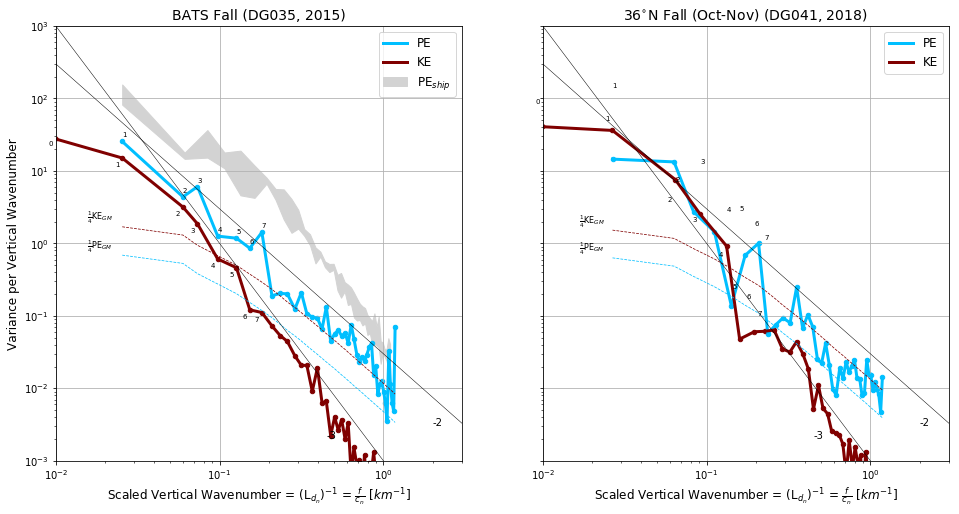

In [180]:
# - load BATS
pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_energy_apr2019.pkl', 'rb')
DGB = pickle.load(pkl_file)
pkl_file.close()
bats_dg_KE = DGB['KE']
bats_dg_PE = DGB['PE']
bats_dg_bckgrds = DGB['background_eddy_indicies_for_energy'][2]  # winter index
bats_dg_KE_all = np.nanmean(DGB['KE_all'][:, bats_dg_bckgrds], axis=1)
bats_dg_PE_all = np.nanmean(DGB['PE_all'][:, bats_dg_bckgrds], axis=1)
bats_dg_c = DGB['c']
bats_dg_f = DGB['f']
bats_dg_depth = DGB['depth']
bats_dg_GMKE = DGB['GMKE']
bats_dg_GMPE = DGB['GMPE']
dk_bats = bats_dg_f / bats_dg_c[1]
sc_x_bats = 1000 * bats_dg_f / bats_dg_c[1:]

# -- load in Station BATs PE Comparison
pkl_file = open('/Users/jake/Desktop/bats/station_bats_pe_jan30.pkl', 'rb')
SB = pickle.load(pkl_file)
pkl_file.close()
sta_bats_pe = SB['PE_by_season']
sta_bats_c = SB['c']
sta_bats_f = np.pi * np.sin(np.deg2rad(31.6)) / (12 * 1800)
sta_bats_dk = sta_bats_f / sta_bats_c[1]
# seasonal and variable spread at bats station for each mode
sta_max = np.nan * np.ones(len(sc_x))
sta_min = np.nan * np.ones(len(sc_x))
dg_per_max = np.nan * np.ones(len(sc_x))
dg_per_min = np.nan * np.ones(len(sc_x))
for i in range(1, mmax+1):
    test1 = np.nanmean(sta_bats_pe[0][i, :])
    test2 = np.nanmean(sta_bats_pe[1][i, :])
    test3 = np.nanmean(sta_bats_pe[2][i, :])
    # test4 = np.nanmean(sta_bats_pe[3][i, :])
    sta_max[i - 1] = np.max([test1, test2, test3])
    sta_min[i - 1] = np.min([test1, test2, test3])
    # dg_per_max[i - 1] = np.nanmax(PE_per_mass_all[i, :])
    # dg_per_min[i - 1] = np.nanmin(PE_per_mass_all[i, :])

# --------------------------------------------------------------------
# - comparison plot of 36N and BATS
fig0, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Station (by season)
ax0.fill_between(1000 * sta_bats_f / sta_bats_c[1:mmax + 1], sta_min / sta_bats_dk, sta_max / sta_bats_dk,
                 label='PE$_{ship}$', color='#D3D3D3')
scols = ['#00BFFF', '#6B8E23', '#800000']
# DG PE avg. (36N)
inn = bckgrds[0]
PE_p = ax1.plot(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=scols[0], label='PE', linewidth=3)
ax1.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=scols[0], s=20)
# DG KE (36N)
KE_p = ax1.plot(1000 * f_ref / c[1:], np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=scols[2], label='KE', linewidth=3)
ax1.scatter(1000 * f_ref / c[1:], np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=scols[2], s=20)                                         # DG KE
KE_p = ax1.plot([10 ** -2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_0[0:2, inn], axis=1) / dk, color=scols[2], linewidth=3)        # DG KE_0
ax1.scatter(10 ** -2, np.nanmean(HKE_per_mass_0[0, inn]) / dk, color=scols[2], s=20, facecolors='none')                   # DG KE_0

# DG PE avg. (BATS)
ax0.plot(sc_x_bats, bats_dg_PE_all[1:] / dk_bats, color=scols[0], label='PE', linewidth=3)
ax0.scatter(sc_x_bats, bats_dg_PE_all[1:] / dk_bats, color=scols[0], s=20)
# DG KE (BATS)
ax0.plot(1000 * bats_dg_f / bats_dg_c[1:], bats_dg_KE_all[1:] / dk_bats, color=scols[2], label=r'KE', linewidth=3)
ax0.scatter(sc_x_bats, bats_dg_KE_all[1:] / dk_bats, color=scols[2], s=20)                                         # DG KE
ax0.plot([10 ** -2, 1000 * bats_dg_f / bats_dg_c[1]], bats_dg_KE_all[0:2] / dk_bats, color=scols[2], linewidth=3)        # DG KE_0
ax0.scatter(10 ** -2, bats_dg_KE_all[0] / dk_bats, color=scols[2], s=20, facecolors='none')                   # DG KE_0
nums = '1', '2', '3', '4', '5', '6', '7', '8'
for i in range(1, 8):
    ax0.text( (1000 * bats_dg_f / bats_dg_c[i]) - (1/10)*(1000 * bats_dg_f / bats_dg_c[i]),
              (bats_dg_KE_all[i] / dk_bats) - (1/4)*(bats_dg_KE_all[i] / dk_bats), nums[i - 1], fontsize=7, color='k')
    ax0.text( (1000 * bats_dg_f / bats_dg_c[i]),
              (bats_dg_PE_all[i] / dk_bats) + (1/7)*(bats_dg_PE_all[i] / dk_bats), nums[i - 1], fontsize=7, color='k')
            #  + (1/15)*(1000 * bats_dg_f / bats_dg_c[i])

    ax1.text((1000 * f_ref / c[i]) - (1/10)*(1000 * f_ref / c[i]),
              (avg_KE[i] / dk) - (1/4)*(avg_KE[i] / dk), nums[i - 1], fontsize=7, color='k')
    ax1.text((1000 * f_ref / c[i]),
              (avg_PE[i] / dk) + (1/7)*(avg_PE[i] / dk), nums[i - 1], fontsize=7, color='k')
              #  + (1/15)*(1000 * f_ref / c[i])
ax0.text(9 * 10 ** -3, (bats_dg_KE_all[0] / dk_bats) - 5, '0', color='k', fontsize=7)
ax1.text(9 * 10 ** -3, (avg_KE[0] / dk) - 5, '0', color='k', fontsize=7)

# GM
# ax0.plot(sc_x, 0.25 * PE_GM / dk, linestyle='--', color='k', linewidth=0.75)
ax1.plot(sc_x, 0.25 * GMPE / dk, color=scols[0], linewidth=0.75, linestyle='--')
ax1.text(sc_x[0] - .01, 0.4 * GMPE[1] / dk, r'$\frac{1}{4}$PE$_{GM}$', fontsize=8)
# ax0.plot(np.array([10**-2, 10]), [PE_SD / dk, PE_SD / dk], linestyle='--', color='k', linewidth=0.75)
ax1.plot(sc_x, 0.25 * GMKE / dk, color=scols[2], linewidth=0.75, linestyle='--')
ax1.text(sc_x[0] - .01, 0.4 * GMKE[1] / dk, r'$\frac{1}{4}$KE$_{GM}$', fontsize=8)

# ax0.plot(sc_x, 0.25 * PE_GM / dk, linestyle='--', color='k', linewidth=0.75)
ax0.plot(sc_x_bats, 0.25 * bats_dg_GMPE / dk_bats, color=scols[0], linewidth=0.75, linestyle='--')
ax0.text(sc_x_bats[0] - .01, 0.4 * bats_dg_GMPE[1] / dk_bats, r'$\frac{1}{4}$PE$_{GM}$', fontsize=8)
# ax0.plot(np.array([10**-2, 10]), [PE_SD / dk, PE_SD / dk], linestyle='--', color='k', linewidth=0.75)
ax0.plot(sc_x_bats, 0.25 * bats_dg_GMKE / dk_bats, color=scols[2], linewidth=0.75, linestyle='--')
ax0.text(sc_x_bats[0] - .01, 0.4 * bats_dg_GMKE[1] / dk_bats, r'$\frac{1}{4}$KE$_{GM}$', fontsize=8)

# slopess
ax0.plot([10**-2, 10**0], [10**3, 10**-3], color='k', linewidth=0.5)
ax0.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax0.text(2*10**0, 3*10**-3, '-2', fontsize=10)
ax0.text(4.5*10**-1, 2*10**-3, '-3', fontsize=10)
ax1.plot([10**-2, 10**0], [10**3, 10**-3], color='k', linewidth=0.5)
ax1.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax1.text(2*10**0, 3*10**-3, '-2', fontsize=10)
ax1.text(4.5*10**-1, 2*10**-3, '-3', fontsize=10)

handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=12)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=12)
ax0.set_xlim([10 ** -2, 3 * 10 ** 0])
ax0.set_ylim([1 * 10 ** (-3), 1 * 10 ** 3])
ax1.set_xlim([10 ** -2, 3 * 10 ** 0])
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')
ax0.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=12)
ax0.set_ylabel('Variance per Vertical Wavenumber', fontsize=12)  # ' (and Hor. Wavenumber)')
ax0.set_title('BATS Fall (DG035, 2015)', fontsize=14)
ax1.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=12)
ax1.set_title(r'36$^{\circ}$N Fall (Oct-Nov) (DG041, 2018)', fontsize=14)
ax0.grid()
plot_pro(ax1)
fig0.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_04_18/dg_bats_36n_energy_comp_sum.jpg", dpi=300)